# **ACCEL DATA ANALYSIS**
------------------------------------------------
>
> ## [github page](https://github.com/willakuffo/accel_iot_data_collection)

In [557]:
import pickle
import pandas as pd


## Data description
> The data was collected with the `acceldatacollector.py` script found in the [github](https://github.com/willakuffo/accel_iot_data_collection) repository. 
>
> The data was collected using 2 separate sensors. The **HC-SR04** Ultrasonic sensor and the **MPU6050** .
>
> Each episode is a list of dictionaries whose keys represent the features used for training and prediction.
> The len of the list represents the number of timesteps per episode (The number of datapoints sampled per episode).
> ## `Keys or features`
> -------------------
>`d(travel_dist)` The change in the travel distance calculated from the **HC-SR04**
>
>`x,y,z` The accelerometer readings in the x, y and z direction from the **MPU6050**
>
>`dx,dy,dz` The change accelerometer readings (jerk -->3rd derivative) in the x, y and z direction from the **MPU6050**
>
> `dt` sampled time
>
> `travel_dist` The distance travelled since the beginning of the eposide
> 
>`travel_time` The time taken to travel up to that point

In [558]:
data = None
with open('data.pickle','rb') as file:
    data = pickle.load(file)

> ### Construct DataFrame from episodes
>
>

In [559]:
df = pd.DataFrame({}) #initialize dataframe to concat all episodes

#Go through each episode (type dict) and concat to build the entire dataset
for episode in data:
    subdf = pd.DataFrame(episode)
    #print(subdf)
    df = pd.concat([df,subdf]) #concat acccording to columns

df

C:\Users\pc\Anaconda3\envs\gpubase\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,d(travel_dist),dt,dx,dy,dz,travel_dist,travel_time,v(t),x,y,z
0,-6.8729,2.371803,-0.093374,-0.079009,0.119710,-6.8729,2.371837,-2.897753,2.738967,-0.995988,-9.461885
1,-0.7300,0.101271,0.047884,0.028730,-0.028730,-7.6029,2.473090,-7.208371,2.786851,-0.967257,-9.490615
2,0.7300,0.100762,-0.158017,0.179565,0.059855,-6.8729,2.573853,7.244803,2.628833,-0.787692,-9.430760
3,0.8800,0.100860,0.131681,-0.165200,-0.100556,-5.9929,2.674714,8.724976,2.760515,-0.952892,-9.531317
4,-2.0400,0.100954,-0.150835,-0.028730,-0.069432,-8.0329,2.775668,-20.207212,2.609680,-0.981623,-9.600749
...,...,...,...,...,...,...,...,...,...,...,...
35,0.6100,0.100359,0.033519,-0.031125,0.684742,22.9655,5.750833,6.078196,2.363077,-0.905008,-9.119514
36,1.5000,0.109342,-0.442927,-1.735796,0.648829,24.4655,5.860174,13.718442,1.920150,-2.640804,-8.470685
37,0.8500,0.108834,0.191536,1.077391,-1.565808,25.3155,5.969007,7.810040,2.111686,-1.563414,-10.036493
38,0.4700,0.108271,0.186748,-0.368707,1.319205,25.7855,6.077279,4.340945,2.298434,-1.932121,-8.717288


>  ## **Functions to draw out episode samples** 
>-------------------------------------------------
> By creating lower triangular matrices of each episode  dataframe and padding the upper part with zeros
>
> Using this, we are able to create more features increasing the resolution of the dataset and making it more robust for real world prediction applications. This may also increase increase the sample size by increasing the rows in the dataset. However this depends on the nature of the dataset.
>
> `NB` One crucial advantage of doing this is that it allows us to create `time sampled features` and `make time sampled predictions`
>
>`Time Sampled Features` are extra features or columns created after the episodes are drawn out. Therefore, a feature or
>
>column `x` which is the acceleration in the x direction will have time sampled features as `xo,x1...xn` which represents the feature x when sampled at time `to,t1...tn` or from time `to --> tn`.
>
>`Time Sampled Predictions` are made using the time sampled features. So if at time `to`, x will have one time sampled feature >`xo` leaving the others to be 0. Therefore at t1, x will have 2 time sampled features `xo,x1` leaving the rest to be 0. >Predictions therefore can be made with any of these scenarios up to the maximum timestep 
>`to...t39` for `xo...x39`. This represents the 40 timesteps per episode 

In [560]:

def create_diagonal_padding(series):
  mat_padded = pd.DataFrame({})
  for i in range(1,len(series)+1):
    seriescopy = series.copy()
    seriescopy[i:len(seriescopy)] = 0
    mat_padded = pd.concat([mat_padded,seriescopy],axis = 1)
    new_mat = mat_padded.T


  timekeys = []
  for i in range(len(series)):
    timekeys.append(series.name+str(i))
  new_mat.columns = timekeys
  new_mat.index = range(0,len(series))

  #print(new_mat.head())
  #print(new_mat.tail())
      
  return new_mat
    #print(seriescopy)
    #print(a)


In [561]:
def remake_df_with_padded(features_to_pad = None, from_original = None, features_to_maintain = None):
  '''rebuild new epsiode dataframe with drawn and padded features'''
  new_df = pd.DataFrame({})
  for feature in features_to_pad:
    padded_mat = create_diagonal_padding(from_original[feature])
    new_df = pd.concat([new_df,padded_mat],axis = 1)
  
  if features_to_maintain != None: 
    for keep in features_to_maintain:
      new_df = pd.concat([new_df,from_original[keep]],axis = 1)
  
  return new_df

In [562]:
#newDF = remake_df_with_padded(features_to_maintain=['travel_time','travel_dist','v(t)','d(travel_dist)'],features_to_pad= ['x','y','z','dx','dy','dz'],from_original = df)
#newDF = remake_df_with_padded(features_to_pad= ['x','y','z','dx','dy','dz'],from_original = df)

In [563]:
def get_final_df():
    '''Go through all episodes and rebuild new dataframe with increased features'''
    old_df = pd.DataFrame({})
    i = 1
    for episode in data:
        episode_df = pd.DataFrame(episode)
        newDF = remake_df_with_padded(features_to_maintain=['travel_time','travel_dist','v(t)','d(travel_dist)','dt'],
                                      features_to_pad= ['x','y','z','dx','dy','dz'],from_original = episode_df)
        newDF = pd.concat([old_df,newDF])
        old_df = newDF
        print('build progress:',str(i)+'/'+str(len(data)),'--->',round(100*(i/len(data)),2),'%')
        i +=1
        
    return newDF

In [564]:
#make new dataset from all episodes
finaldf = get_final_df() 

build progress: 1/100 ---> 1.0 %
build progress: 2/100 ---> 2.0 %
build progress: 3/100 ---> 3.0 %
build progress: 4/100 ---> 4.0 %
build progress: 5/100 ---> 5.0 %
build progress: 6/100 ---> 6.0 %
build progress: 7/100 ---> 7.0 %
build progress: 8/100 ---> 8.0 %
build progress: 9/100 ---> 9.0 %
build progress: 10/100 ---> 10.0 %
build progress: 11/100 ---> 11.0 %
build progress: 12/100 ---> 12.0 %
build progress: 13/100 ---> 13.0 %
build progress: 14/100 ---> 14.0 %
build progress: 15/100 ---> 15.0 %
build progress: 16/100 ---> 16.0 %
build progress: 17/100 ---> 17.0 %
build progress: 18/100 ---> 18.0 %
build progress: 19/100 ---> 19.0 %
build progress: 20/100 ---> 20.0 %
build progress: 21/100 ---> 21.0 %
build progress: 22/100 ---> 22.0 %
build progress: 23/100 ---> 23.0 %
build progress: 24/100 ---> 24.0 %
build progress: 25/100 ---> 25.0 %
build progress: 26/100 ---> 26.0 %
build progress: 27/100 ---> 27.0 %
build progress: 28/100 ---> 28.0 %
build progress: 29/100 ---> 29.0 %
bui

### Resulting Dataframe after drawing out episodes
> Note the time sampled features present 

In [565]:
finaldf.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,dz35,dz36,dz37,dz38,dz39,travel_time,travel_dist,v(t),d(travel_dist),dt
0,2.738967,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.371837,-6.8729,-2.897753,-6.8729,2.371803
1,2.738967,2.786851,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.473090,-7.6029,-7.208371,-0.7300,0.101271
2,2.738967,2.786851,2.628833,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.573853,-6.8729,7.244803,0.7300,0.100762
3,2.738967,2.786851,2.628833,2.760515,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.674714,-5.9929,8.724976,0.8800,0.100860
4,2.738967,2.786851,2.628833,2.760515,2.60968,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.775668,-8.0329,-20.207212,-2.0400,0.100954


### The Advantage of increased features
----------------------------------------------
> In hopes of imporving the resolution of the dataset
>
> In the real world application, it allows to test for the robustness of different predictions
> **The Po to P40** time feature prediction
> The time feature prediction makes a prediction depending on which number
of timed features have been filled with actual sampled > > data other than the padded 0s

In [566]:

#new df with increased features
finaldf.shape

(4000, 245)

In [567]:
#notice the time sampled features
finaldf.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'dz35', 'dz36', 'dz37', 'dz38', 'dz39', 'travel_time', 'travel_dist',
       'v(t)', 'd(travel_dist)', 'dt'],
      dtype='object', length=245)

In [568]:
# separate input and output features

X = finaldf.copy().drop(['v(t)','travel_dist','d(travel_dist)'],axis = 1)
Y = finaldf[['v(t)','travel_dist','d(travel_dist)']]

In [569]:
X.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,dz32,dz33,dz34,dz35,dz36,dz37,dz38,dz39,travel_time,dt
0,2.738967,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.371837,2.371803
1,2.738967,2.786851,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.473090,0.101271
2,2.738967,2.786851,2.628833,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.573853,0.100762
3,2.738967,2.786851,2.628833,2.760515,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.674714,0.100860
4,2.738967,2.786851,2.628833,2.760515,2.60968,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.775668,0.100954


In [570]:
# Y is what we want to predict. These are trusted values from the Ultrasonic sensor which is to be mapped as an output to the input
Y

,v(t),travel_dist,d(travel_dist)
0,-2.897753,-6.8729,-6.8729
1,-7.208371,-7.6029,-0.7300
2,7.244803,-6.8729,0.7300
3,8.724976,-5.9929,0.8800
4,-20.207212,-8.0329,-2.0400
...,...,...,...
35,6.078196,22.9655,0.6100
36,13.718442,24.4655,1.5000
37,7.810040,25.3155,0.8500
38,4.340945,25.7855,0.4700


In [571]:
#scale/normalize features 

from sklearn.preprocessing import MinMaxScaler

In [572]:
sc = MinMaxScaler()
Xscaled = sc.fit_transform(X)
Yscaled = sc.fit_transform(Y)


In [573]:
Xscaled

array([[6.52040816e-01, 1.13488372e-01, 0.00000000e+00, ...,
        5.15854922e-01, 1.19400072e-01, 9.23340854e-01],
       [6.52040816e-01, 6.54883721e-01, 0.00000000e+00, ...,
        5.15854922e-01, 1.39658758e-01, 5.14161835e-04],
       [6.52040816e-01, 6.54883721e-01, 7.56719504e-01, ...,
        5.15854922e-01, 1.59819082e-01, 3.07179234e-04],
       ...,
       [5.53061224e-01, 5.75813953e-01, 6.82977257e-01, ...,
        5.15854922e-01, 8.39116153e-01, 3.58808602e-03],
       [5.53061224e-01, 5.75813953e-01, 6.82977257e-01, ...,
        5.15854922e-01, 8.60778959e-01, 3.35930048e-03],
       [5.53061224e-01, 5.75813953e-01, 6.82977257e-01, ...,
        3.95233161e-01, 8.82371643e-01, 3.21675768e-03]])

In [574]:
from sklearn.model_selection import train_test_split

In [575]:
#split data for training(70%) and testing(30%)
xtrain,xtest,ytrain,ytest = train_test_split(Xscaled,Yscaled,test_size = 0.3)

In [576]:
xtrain.shape,xtest.shape

((2800, 242), (1200, 242))

In [577]:
#importations for ML
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.metrics import RootMeanSquaredError

In [578]:
#define model
model = Sequential()
model.add(Dense(units = xtrain.shape[1],input_dim = xtrain.shape[1],activation = 'relu'))
model.add(Dense(units = 512,activation = 'relu'))
model.add(Dense(units = 256,activation = 'relu'))
model.add(Dense(units = 128,activation = 'relu'))
model.add(Dense(units = 64,activation = 'relu'))
model.add(Dense(units = 32,activation = 'relu'))
model.add(Dense(units = 16,activation = 'relu'))
model.add(Dense(units = 8,activation = 'relu'))
model.add(Dense(units = ytrain.shape[1],activation = 'linear'))
model.compile(optimizer = Adam(learning_rate = 0.001),metrics = ['mse','mae',RootMeanSquaredError()],loss ='mse' )

In [579]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 242)               58806     
_________________________________________________________________
dense_236 (Dense)            (None, 512)               124416    
_________________________________________________________________
dense_237 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_238 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_239 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_240 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_241 (Dense)            (None, 16)              

In [580]:
hist = model.fit(xtrain,ytrain,validation_data=(xtest,ytest),epochs = 50,
                callbacks = [ModelCheckpoint(filepath = 'accelmodel.hdf5',
                                            monitor = 'val_root_mean_squared_error',mode = 'min',save_best_only = True)])

Train on 2800 samples, validate on 1200 samples
Epoch 1/50
2800/2800 [==============================] - 1s 421us/step - loss: 0.0336 - mse: 0.0336 - mae: 0.1300 - root_mean_squared_error: 0.1832 - val_loss: 0.0138 - val_mse: 0.0138 - val_mae: 0.0871 - val_root_mean_squared_error: 0.1176
Epoch 2/50
2800/2800 [==============================] - 1s 362us/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0594 - root_mean_squared_error: 0.0988 - val_loss: 0.0120 - val_mse: 0.0120 - val_mae: 0.0800 - val_root_mean_squared_error: 0.1095
Epoch 3/50
2800/2800 [==============================] - 2s 703us/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0601 - root_mean_squared_error: 0.0965 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0633 - val_root_mean_squared_error: 0.1002
Epoch 4/50
2800/2800 [==============================] - 2s 700us/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0539 - root_mean_squared_error: 0.0919 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0597 - val_root_mean_squared_error:

Epoch 35/50
2800/2800 [==============================] - 1s 315us/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0354 - root_mean_squared_error: 0.0603 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0384 - val_root_mean_squared_error: 0.0671
Epoch 36/50
2800/2800 [==============================] - 1s 252us/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0357 - root_mean_squared_error: 0.0606 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0361 - val_root_mean_squared_error: 0.0652
Epoch 37/50
2800/2800 [==============================] - 1s 269us/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0335 - root_mean_squared_error: 0.0585 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0362 - val_root_mean_squared_error: 0.0657
Epoch 38/50
2800/2800 [==============================] - 1s 386us/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0322 - root_mean_squared_error: 0.0574 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0336 - val_root_mean_squared_error: 0.0628
Epoch 39/50
2800/2800 [=============

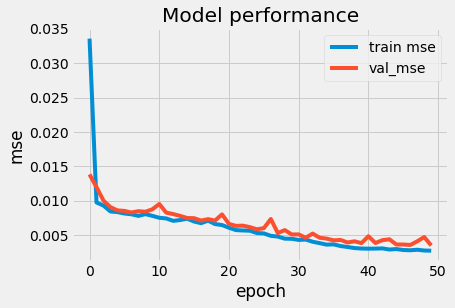

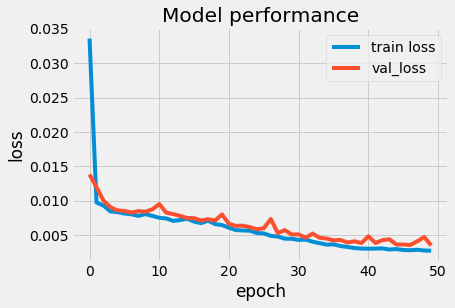

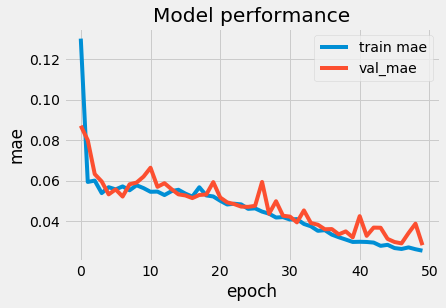

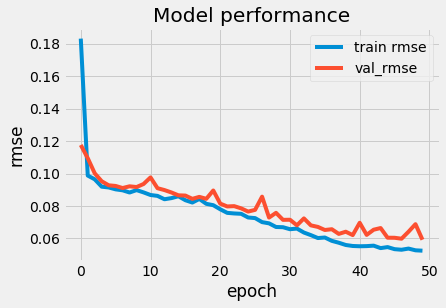

In [581]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Model performance')
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.legend(['train mse','val_mse'])
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

plt.figure()
plt.title('Model performance')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train loss','val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.title('Model performance')
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.legend(['train mae','val_mae'])
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

plt.figure()
plt.title('Model performance')
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.legend(['train rmse','val_rmse'])
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.show()

In [582]:
import numpy as np
import time

In [583]:
#evaluating prediction time
st = time.time()
sc.inverse_transform(model.predict(np.reshape(xtrain[1],(1,-1))))
time.time()-st

0.11668658256530762

# Predictions
> **Training data**

In [584]:
#pred
actual_travel_train = []
predicted_travel_train = []

actual_velocity_train = []
predicted_velocity_train = []

actual_distance_change_train = []
predicted_distance_change_train = []


for i in range(len(xtrain)):

    actual = sc.inverse_transform(np.reshape(ytrain[i],(1,-1)))
    predicted = sc.inverse_transform(model.predict(np.reshape(xtrain[i],(1,-1))))
    
    actual_velocity_train.append(actual[0][0])
    predicted_velocity_train.append(predicted[0][0])
    
    actual_travel_train.append(actual[0][1])
    predicted_travel_train.append(predicted[0][1])
    
    actual_distance_change_train.append(actual[0][2])
    predicted_distance_change_train.append(predicted[0][2])
    
    
    print('act dist: ',round(actual[0][1],2),' pred:',round(predicted[0][1],2),'       act vel: ',
          round(actual[0][0],2),' pred: ',round(predicted[0][0],2),
         '      act chng: ',round(actual[0][2],2),' pred:',round(predicted[0][2],2))

    


act dist:  -23.12  pred: -18.04        act vel:  25.15  pred:  -10.99       act chng:  2.6  pred: -1.2
act dist:  -1.58  pred: -0.01        act vel:  -5.55  pred:  -1.36       act chng:  -0.6  pred: -0.19
act dist:  15.83  pred: 20.85        act vel:  29.23  pred:  9.78       act chng:  3.22  pred: 0.98
act dist:  -60.77  pred: -57.19        act vel:  -18.71  pred:  -31.91       act chng:  -1.96  pred: -3.4
act dist:  0.04  pred: 2.97        act vel:  4.71  pred:  0.23       act chng:  0.51  pred: -0.02
act dist:  2.02  pred: 2.63        act vel:  27.72  pred:  0.05       act chng:  2.83  pred: -0.04
act dist:  35.84  pred: 45.97        act vel:  -55.77  pred:  23.2       act chng:  -5.85  pred: 2.4
act dist:  -2.87  pred: -0.37        act vel:  3.99  pred:  -1.55       act chng:  0.42  pred: -0.21
act dist:  56.98  pred: 58.5        act vel:  3.41  pred:  29.9       act chng:  0.36  pred: 3.1
act dist:  -11.2  pred: -1.21        act vel:  37.15  pred:  -2.0       act chng:  3.85  pred

act dist:  -4.55  pred: 2.37        act vel:  -15.89  pred:  -0.09       act chng:  -1.68  pred: -0.06
act dist:  -8.29  pred: -2.74        act vel:  -4.09  pred:  -2.82       act chng:  -0.41  pred: -0.34
act dist:  -1.55  pred: 2.21        act vel:  -0.7  pred:  -0.17       act chng:  -1.55  pred: -0.06
act dist:  -1.8  pred: 3.72        act vel:  -0.88  pred:  0.63       act chng:  -1.8  pred: 0.02
act dist:  -1.06  pred: 1.96        act vel:  -0.68  pred:  -0.31       act chng:  -0.07  pred: -0.08
act dist:  0.12  pred: -0.92        act vel:  -0.81  pred:  -1.85       act chng:  -0.09  pred: -0.24
act dist:  27.63  pred: 3.08        act vel:  16.4  pred:  0.29       act chng:  1.79  pred: -0.02
act dist:  -1.57  pred: 10.62        act vel:  -4.35  pred:  4.32       act chng:  -0.48  pred: 0.41
act dist:  8.06  pred: 1.13        act vel:  33.48  pred:  -0.75       act chng:  3.48  pred: -0.13
act dist:  -29.38  pred: -20.44        act vel:  -12.22  pred:  -12.27       act chng:  -1.

act dist:  0.77  pred: -0.84        act vel:  -0.99  pred:  -1.81       act chng:  -0.1  pred: -0.24
act dist:  -0.07  pred: 9.58        act vel:  -0.98  pred:  3.76       act chng:  -0.1  pred: 0.35
act dist:  31.5  pred: 21.57        act vel:  0.0  pred:  10.17       act chng:  0.0  pred: 1.02
act dist:  17.7  pred: 17.01        act vel:  10.82  pred:  7.73       act chng:  1.09  pred: 0.77
act dist:  21.06  pred: -2.97        act vel:  3.88  pred:  -2.94       act chng:  0.4  pred: -0.36
act dist:  -35.64  pred: -39.76        act vel:  40.43  pred:  -22.59       act chng:  4.17  pred: -2.42
act dist:  19.86  pred: 31.95        act vel:  -3.77  pred:  15.71       act chng:  -0.39  pred: 1.61
act dist:  -0.26  pred: -1.44        act vel:  -3.19  pred:  -2.12       act chng:  -0.35  pred: -0.27
act dist:  -21.04  pred: -9.33        act vel:  -4.64  pred:  -6.34       act chng:  -0.51  pred: -0.71
act dist:  -7.02  pred: 6.28        act vel:  -6.46  pred:  2.0       act chng:  -0.69  pr

act dist:  44.16  pred: 41.51        act vel:  2.55  pred:  20.82       act chng:  0.26  pred: 2.15
act dist:  -12.6  pred: -4.21        act vel:  -18.61  pred:  -3.61       act chng:  -1.91  pred: -0.43
act dist:  -0.14  pred: -3.57        act vel:  0.0  pred:  -3.26       act chng:  0.0  pred: -0.39
act dist:  49.45  pred: 10.08        act vel:  -51.57  pred:  4.03       act chng:  -5.6  pred: 0.38
act dist:  -0.35  pred: 0.52        act vel:  0.81  pred:  -1.08       act chng:  0.09  pred: -0.16
act dist:  -22.76  pred: -1.91        act vel:  -466.74  pred:  -2.37       act chng:  -51.54  pred: -0.3
act dist:  -0.37  pred: 1.42        act vel:  -0.17  pred:  -0.6       act chng:  -0.37  pred: -0.11
act dist:  11.84  pred: 7.18        act vel:  6.93  pred:  2.48       act chng:  0.7  pred: 0.22
act dist:  -32.19  pred: -19.78        act vel:  -22.04  pred:  -11.92       act chng:  -2.37  pred: -1.3
act dist:  -10.45  pred: 1.99        act vel:  -0.91  pred:  -0.29       act chng:  -0

act dist:  -1.41  pred: 0.46        act vel:  7.61  pred:  -1.11       act chng:  0.85  pred: -0.16
act dist:  42.57  pred: 5.62        act vel:  -52.45  pred:  1.65       act chng:  -5.59  pred: 0.13
act dist:  -17.1  pred: 1.69        act vel:  -6.77  pred:  -0.45       act chng:  -17.1  pred: -0.09
act dist:  31.49  pred: 30.46        act vel:  4.98  pred:  14.92       act chng:  0.51  pred: 1.52
act dist:  -0.53  pred: -0.72        act vel:  0.0  pred:  -1.74       act chng:  0.0  pred: -0.23
act dist:  -7.79  pred: -3.43        act vel:  -26.56  pred:  -3.19       act chng:  -2.73  pred: -0.38
act dist:  0.77  pred: -0.39        act vel:  0.0  pred:  -1.56       act chng:  0.0  pred: -0.21
act dist:  27.6  pred: 36.07        act vel:  0.77  pred:  17.91       act chng:  0.08  pred: 1.84
act dist:  0.4  pred: -3.31        act vel:  9.81  pred:  -3.12       act chng:  1.04  pred: -0.37
act dist:  -0.9  pred: -3.39        act vel:  11.28  pred:  -3.17       act chng:  1.26  pred: -0.

act dist:  0.45  pred: -0.45        act vel:  2.78  pred:  -1.6       act chng:  0.28  pred: -0.21
act dist:  13.76  pred: 10.54        act vel:  2.34  pred:  4.27       act chng:  0.26  pred: 0.4
act dist:  0.16  pred: 1.18        act vel:  -0.9  pred:  -0.73       act chng:  -0.1  pred: -0.12
act dist:  -0.22  pred: -2.3        act vel:  0.46  pred:  -2.59       act chng:  0.05  pred: -0.32
act dist:  3.35  pred: 1.72        act vel:  -62.69  pred:  -0.44       act chng:  -6.37  pred: -0.09
act dist:  -3.68  pred: 2.28        act vel:  -7.84  pred:  -0.14       act chng:  -0.83  pred: -0.06
act dist:  21.15  pred: 22.49        act vel:  -1.16  pred:  10.66       act chng:  -0.12  pred: 1.08
act dist:  21.42  pred: 22.66        act vel:  8.21  pred:  10.75       act chng:  0.83  pred: 1.09
act dist:  5.87  pred: 10.7        act vel:  28.82  pred:  4.36       act chng:  3.17  pred: 0.41
act dist:  13.13  pred: 15.85        act vel:  5.51  pred:  7.11       act chng:  0.58  pred: 0.7
ac

act dist:  -58.47  pred: -46.08        act vel:  -19.22  pred:  -25.97       act chng:  -2.06  pred: -2.78
act dist:  -70.17  pred: -70.99        act vel:  -16.63  pred:  -39.28       act chng:  -1.87  pred: -4.18
act dist:  -1.58  pred: -0.03        act vel:  4.18  pred:  -1.37       act chng:  0.42  pred: -0.19
act dist:  56.62  pred: 56.16        act vel:  -3.89  pred:  28.65       act chng:  -0.41  pred: 2.97
act dist:  2.5  pred: 7.63        act vel:  28.82  pred:  2.72       act chng:  3.09  pred: 0.24
act dist:  48.39  pred: 53.89        act vel:  28.73  pred:  27.43       act chng:  3.04  pred: 2.84
act dist:  7.72  pred: 9.24        act vel:  14.92  pred:  3.58       act chng:  1.58  pred: 0.33
act dist:  49.23  pred: 17.46        act vel:  107.67  pred:  7.97       act chng:  11.4  pred: 0.79
act dist:  -36.82  pred: -37.4        act vel:  18.46  pred:  -21.34       act chng:  2.02  pred: -2.29
act dist:  12.26  pred: 10.86        act vel:  23.79  pred:  4.45       act chng: 

act dist:  -3.48  pred: -2.87        act vel:  -8.34  pred:  -2.89       act chng:  -0.85  pred: -0.35
act dist:  -1.54  pred: 1.56        act vel:  0.0  pred:  -0.52       act chng:  0.0  pred: -0.1
act dist:  -2.92  pred: 2.54        act vel:  -1.26  pred:  0.0       act chng:  -2.92  pred: -0.05
act dist:  -1.0  pred: 3.95        act vel:  4.98  pred:  0.76       act chng:  0.55  pred: 0.03
act dist:  3.29  pred: 6.36        act vel:  12.55  pred:  2.04       act chng:  1.43  pred: 0.17
act dist:  -0.37  pred: 4.31        act vel:  -2.94  pred:  0.94       act chng:  -0.3  pred: 0.05
act dist:  0.16  pred: 1.26        act vel:  0.18  pred:  -0.68       act chng:  0.02  pred: -0.12
act dist:  -20.93  pred: -12.29        act vel:  -69.68  pred:  -7.92       act chng:  -7.65  pred: -0.88
act dist:  -1.42  pred: 0.54        act vel:  -3.31  pred:  -1.07       act chng:  -0.37  pred: -0.16
act dist:  -26.78  pred: -45.12        act vel:  35.91  pred:  -25.46       act chng:  3.74  pred: 

act dist:  -37.43  pred: -35.96        act vel:  14.93  pred:  -20.56       act chng:  1.59  pred: -2.21
act dist:  1.76  pred: -0.69        act vel:  21.67  pred:  -1.73       act chng:  2.19  pred: -0.23
act dist:  28.56  pred: -0.07        act vel:  311.9  pred:  -1.39       act chng:  31.81  pred: -0.19
act dist:  -24.32  pred: -22.1        act vel:  262.13  pred:  -13.16       act chng:  27.03  pred: -1.43
act dist:  38.2  pred: 35.84        act vel:  -0.47  pred:  17.79       act chng:  -0.05  pred: 1.83
act dist:  1.87  pred: 5.14        act vel:  17.25  pred:  1.39       act chng:  1.74  pred: 0.1
act dist:  0.04  pred: -1.27        act vel:  0.1  pred:  -2.03       act chng:  0.01  pred: -0.26
act dist:  4.91  pred: 7.96        act vel:  19.25  pred:  2.9       act chng:  1.95  pred: 0.26
act dist:  -3.23  pred: 8.17        act vel:  1.13  pred:  3.01       act chng:  0.12  pred: 0.27
act dist:  6.93  pred: 7.33        act vel:  27.04  pred:  2.56       act chng:  3.03  pred: 

act dist:  41.89  pred: 35.23        act vel:  -4.73  pred:  17.46       act chng:  -0.48  pred: 1.79
act dist:  -21.51  pred: -13.93        act vel:  -31.19  pred:  -8.8       act chng:  -3.46  pred: -0.97
act dist:  -23.46  pred: 1.46        act vel:  -9.21  pred:  -0.57       act chng:  -23.46  pred: -0.11
act dist:  -51.14  pred: -42.17        act vel:  -23.91  pred:  -23.88       act chng:  -2.58  pred: -2.56
act dist:  31.42  pred: 24.26        act vel:  21.03  pred:  11.6       act chng:  2.21  pred: 1.18
act dist:  0.41  pred: -2.71        act vel:  -0.49  pred:  -2.8       act chng:  -0.05  pred: -0.34
act dist:  -1.56  pred: -1.2        act vel:  -5.0  pred:  -2.0       act chng:  -0.51  pred: -0.26
act dist:  5.51  pred: 6.94        act vel:  7.64  pred:  2.35       act chng:  0.8  pred: 0.2
act dist:  0.16  pred: -0.98        act vel:  -0.97  pred:  -1.88       act chng:  -0.1  pred: -0.24
act dist:  -0.16  pred: -2.96        act vel:  0.0  pred:  -2.93       act chng:  0.0

act dist:  -72.61  pred: -58.52        act vel:  -17.35  pred:  -32.62       act chng:  -1.95  pred: -3.48
act dist:  63.4  pred: 61.01        act vel:  3.81  pred:  31.24       act chng:  0.41  pred: 3.24
act dist:  29.51  pred: -1.99        act vel:  329.11  pred:  -2.42       act chng:  33.85  pred: -0.3
act dist:  38.54  pred: 39.43        act vel:  -4.41  pred:  19.71       act chng:  -0.48  pred: 2.03
act dist:  0.02  pred: -2.16        act vel:  0.0  pred:  -2.51       act chng:  0.0  pred: -0.31
act dist:  32.96  pred: 38.17        act vel:  -22.77  pred:  19.04       act chng:  -2.32  pred: 1.96
act dist:  -31.75  pred: -28.67        act vel:  -31.73  pred:  -16.67       act chng:  -3.25  pred: -1.8
act dist:  -1.19  pred: -0.88        act vel:  -58.46  pred:  -1.82       act chng:  -6.39  pred: -0.24
act dist:  0.04  pred: 0.06        act vel:  0.1  pred:  -1.32       act chng:  0.01  pred: -0.19
act dist:  -33.57  pred: -32.52        act vel:  -25.2  pred:  -18.73       act 

act dist:  -2.38  pred: 0.1        act vel:  -10.52  pred:  -1.3       act chng:  -1.09  pred: -0.18
act dist:  -45.33  pred: -46.16        act vel:  -26.46  pred:  -26.02       act chng:  -2.68  pred: -2.78
act dist:  -1.2  pred: -1.13        act vel:  -8.44  pred:  -1.96       act chng:  -0.86  pred: -0.25
act dist:  10.72  pred: 1.38        act vel:  4.19  pred:  -0.62       act chng:  10.72  pred: -0.11
act dist:  -11.06  pred: -20.18        act vel:  -33.59  pred:  -12.13       act chng:  -3.63  pred: -1.32
act dist:  17.6  pred: 20.75        act vel:  -0.99  pred:  9.73       act chng:  -0.1  pred: 0.98
act dist:  -50.62  pred: -45.93        act vel:  -31.7  pred:  -25.89       act chng:  -3.3  pred: -2.77
act dist:  -0.01  pred: -4.55        act vel:  -0.2  pred:  -3.79       act chng:  -0.02  pred: -0.44
act dist:  -17.46  pred: -8.41        act vel:  -7.78  pred:  -5.85       act chng:  -0.84  pred: -0.66
act dist:  -21.18  pred: -9.13        act vel:  -15.39  pred:  -6.23    

act dist:  49.68  pred: 53.0        act vel:  9.9  pred:  26.96       act chng:  1.02  pred: 2.79
act dist:  0.42  pred: 0.47        act vel:  5.29  pred:  -1.11       act chng:  0.54  pred: -0.16
act dist:  -5.77  pred: 8.25        act vel:  -21.3  pred:  3.05       act chng:  -2.23  pred: 0.28
act dist:  -1.05  pred: 3.07        act vel:  0.72  pred:  0.29       act chng:  0.08  pred: -0.02
act dist:  54.49  pred: 59.39        act vel:  2.05  pred:  30.37       act chng:  0.21  pred: 3.15
act dist:  -15.1  pred: -10.37        act vel:  -15.65  pred:  -6.9       act chng:  -1.71  pred: -0.77
act dist:  -26.56  pred: -12.49        act vel:  -68.67  pred:  -8.03       act chng:  -6.9  pred: -0.89
act dist:  -1.32  pred: 0.03        act vel:  -14.85  pred:  -1.34       act chng:  -1.53  pred: -0.19
act dist:  -42.08  pred: -26.19        act vel:  -28.1  pred:  -15.35       act chng:  -3.06  pred: -1.66
act dist:  -3.74  pred: 2.14        act vel:  -5.57  pred:  -0.21       act chng:  -0.

act dist:  -13.35  pred: -9.67        act vel:  -24.67  pred:  -6.52       act chng:  -2.68  pred: -0.73
act dist:  -36.43  pred: -36.36        act vel:  -27.35  pred:  -20.78       act chng:  -2.96  pred: -2.23
act dist:  -72.52  pred: -54.52        act vel:  -4.48  pred:  -30.48       act chng:  -0.49  pred: -3.25
act dist:  -50.89  pred: -41.32        act vel:  17.19  pred:  -23.43       act chng:  1.95  pred: -2.51
act dist:  -0.24  pred: -3.55        act vel:  3.84  pred:  -3.25       act chng:  0.39  pred: -0.39
act dist:  -53.49  pred: -28.4        act vel:  -17.12  pred:  -16.53       act chng:  -1.89  pred: -1.79
act dist:  -0.01  pred: -2.76        act vel:  0.0  pred:  -2.83       act chng:  0.0  pred: -0.34
act dist:  0.77  pred: -1.33        act vel:  3.02  pred:  -2.07       act chng:  0.31  pred: -0.26
act dist:  -31.25  pred: -33.82        act vel:  3.11  pred:  -19.42       act chng:  0.33  pred: -2.09
act dist:  -55.89  pred: -45.24        act vel:  -8.57  pred:  -25.

act dist:  -7.71  pred: 0.86        act vel:  3.63  pred:  -0.9       act chng:  0.41  pred: -0.14
act dist:  -10.65  pred: -2.62        act vel:  -45.72  pred:  -2.76       act chng:  -4.88  pred: -0.34
act dist:  -10.44  pred: 1.49        act vel:  -488.93  pred:  -0.56       act chng:  -53.65  pred: -0.1
act dist:  38.87  pred: 38.52        act vel:  0.0  pred:  19.22       act chng:  0.0  pred: 1.98
act dist:  44.92  pred: 50.13        act vel:  62.78  pred:  25.43       act chng:  6.85  pred: 2.63
act dist:  18.28  pred: 4.93        act vel:  -303.33  pred:  1.28       act chng:  -32.62  pred: 0.09
act dist:  -0.48  pred: -2.4        act vel:  0.0  pred:  -2.64       act chng:  0.0  pred: -0.32
act dist:  56.72  pred: 56.42        act vel:  15.97  pred:  28.79       act chng:  1.63  pred: 2.98
act dist:  5.91  pred: 0.0        act vel:  -12.92  pred:  -1.36       act chng:  -1.33  pred: -0.19
act dist:  -62.5  pred: -44.39        act vel:  -29.28  pred:  -25.07       act chng:  -3

act dist:  -0.31  pred: 1.05        act vel:  -1.12  pred:  -0.79       act chng:  -0.12  pred: -0.13
act dist:  8.41  pred: 7.46        act vel:  27.9  pred:  2.63       act chng:  2.87  pred: 0.23
act dist:  -14.36  pred: -17.27        act vel:  -63.64  pred:  -10.58       act chng:  -6.73  pred: -1.16
act dist:  56.29  pred: 51.33        act vel:  4.73  pred:  26.06       act chng:  0.48  pred: 2.7
act dist:  19.71  pred: 22.39        act vel:  29.0  pred:  10.6       act chng:  3.18  pred: 1.07
act dist:  -33.21  pred: -49.45        act vel:  -23.59  pred:  -27.77       act chng:  -2.41  pred: -2.97
act dist:  28.53  pred: 31.68        act vel:  -17.73  pred:  15.57       act chng:  -1.81  pred: 1.59
act dist:  -63.91  pred: -62.59        act vel:  -39.22  pred:  -34.79       act chng:  -4.3  pred: -3.71
act dist:  -4.0  pred: 1.04        act vel:  -10.35  pred:  -0.8       act chng:  -1.14  pred: -0.13
act dist:  -6.76  pred: 5.48        act vel:  -9.56  pred:  1.57       act chng

act dist:  0.45  pred: 2.07        act vel:  -1.07  pred:  -0.25       act chng:  -0.11  pred: -0.07
act dist:  -11.98  pred: -9.17        act vel:  -39.87  pred:  -6.25       act chng:  -4.45  pred: -0.7
act dist:  -1.13  pred: 3.45        act vel:  2.8  pred:  0.49       act chng:  0.31  pred: 0.01
act dist:  -0.14  pred: -2.86        act vel:  0.88  pred:  -2.88       act chng:  0.09  pred: -0.35
act dist:  -0.25  pred: -3.21        act vel:  -0.29  pred:  -3.07       act chng:  -0.03  pred: -0.37
act dist:  -1.16  pred: 12.66        act vel:  8.71  pred:  5.41       act chng:  0.91  pred: 0.52
act dist:  -12.01  pred: -0.26        act vel:  -16.05  pred:  -1.49       act chng:  -1.67  pred: -0.2
act dist:  -1.0  pred: -3.22        act vel:  0.0  pred:  -3.08       act chng:  0.0  pred: -0.37
act dist:  -18.72  pred: -10.24        act vel:  -11.59  pred:  -6.83       act chng:  -1.16  pred: -0.76
act dist:  -1.17  pred: -0.79        act vel:  3.8  pred:  -1.78       act chng:  0.39 

act dist:  -29.15  pred: -29.06        act vel:  -13.56  pred:  -16.88       act chng:  -1.41  pred: -1.82
act dist:  -23.88  pred: -27.34        act vel:  -12.33  pred:  -15.96       act chng:  -1.25  pred: -1.73
act dist:  0.14  pred: -0.93        act vel:  0.0  pred:  -1.85       act chng:  0.0  pred: -0.24
act dist:  0.03  pred: -0.32        act vel:  0.0  pred:  -1.52       act chng:  0.0  pred: -0.21
act dist:  10.92  pred: 9.31        act vel:  9.95  pred:  3.62       act chng:  1.07  pred: 0.33
act dist:  0.53  pred: -1.94        act vel:  3.97  pred:  -2.39       act chng:  0.41  pred: -0.3
act dist:  -6.13  pred: -3.58        act vel:  -26.69  pred:  -3.27       act chng:  -2.92  pred: -0.39
act dist:  2.99  pred: -15.23        act vel:  303.95  pred:  -9.49       act chng:  31.47  pred: -1.04
act dist:  -13.76  pred: -2.79        act vel:  -7.53  pred:  -2.85       act chng:  -0.76  pred: -0.35
act dist:  -0.27  pred: 0.29        act vel:  3.81  pred:  -1.2       act chng:  

act dist:  48.52  pred: 57.87        act vel:  -4.63  pred:  29.56       act chng:  -0.47  pred: 3.06
act dist:  0.47  pred: -3.43        act vel:  0.0  pred:  -3.19       act chng:  0.0  pred: -0.38
act dist:  -1.43  pred: 0.64        act vel:  -0.18  pred:  -1.01       act chng:  -0.02  pred: -0.15
act dist:  -0.14  pred: 2.39        act vel:  -1.08  pred:  -0.08       act chng:  -0.11  pred: -0.05
act dist:  -61.47  pred: -40.88        act vel:  -26.63  pred:  -23.19       act chng:  -2.94  pred: -2.49
act dist:  -33.96  pred: -34.71        act vel:  -24.56  pred:  -19.9       act chng:  -2.76  pred: -2.14
act dist:  -17.97  pred: -0.38        act vel:  1.97  pred:  -1.56       act chng:  0.22  pred: -0.21
act dist:  0.73  pred: -1.25        act vel:  0.0  pred:  -2.02       act chng:  0.0  pred: -0.26
act dist:  10.9  pred: 9.02        act vel:  13.58  pred:  3.46       act chng:  1.36  pred: 0.32
act dist:  33.37  pred: 30.18        act vel:  22.86  pred:  14.77       act chng:  2

act dist:  31.4  pred: 40.21        act vel:  0.0  pred:  20.13       act chng:  0.0  pred: 2.07
act dist:  -19.35  pred: -7.83        act vel:  -14.21  pred:  -5.54       act chng:  -1.49  pred: -0.63
act dist:  1.66  pred: 0.15        act vel:  35.77  pred:  -1.28       act chng:  3.68  pred: -0.18
act dist:  0.56  pred: 0.21        act vel:  0.1  pred:  -1.25       act chng:  0.01  pred: -0.18
act dist:  27.96  pred: 1.8        act vel:  11.9  pred:  -0.39       act chng:  27.96  pred: -0.09
act dist:  0.76  pred: -3.28        act vel:  3.04  pred:  -3.11       act chng:  0.31  pred: -0.37
act dist:  21.21  pred: 28.02        act vel:  -26.64  pred:  13.61       act chng:  -2.94  pred: 1.39
act dist:  -2.29  pred: -0.66        act vel:  -8.25  pred:  -1.71       act chng:  -0.85  pred: -0.23
act dist:  27.92  pred: 22.64        act vel:  -55.77  pred:  10.74       act chng:  -5.88  pred: 1.08
act dist:  0.45  pred: 3.14        act vel:  6.88  pred:  0.32       act chng:  0.71  pred:

act dist:  -42.19  pred: -37.5        act vel:  115.27  pred:  -21.39       act chng:  11.79  pred: -2.3
act dist:  -2.61  pred: -3.35        act vel:  -3.81  pred:  -3.15       act chng:  -0.39  pred: -0.38
act dist:  -11.85  pred: 1.81        act vel:  -4.9  pred:  -0.39       act chng:  -0.49  pred: -0.09
act dist:  -62.3  pred: -42.22        act vel:  -22.19  pred:  -23.91       act chng:  -2.47  pred: -2.56
act dist:  21.64  pred: 30.21        act vel:  44.84  pred:  14.78       act chng:  4.73  pred: 1.51
act dist:  -1.08  pred: 0.7        act vel:  -1.08  pred:  -0.98       act chng:  -0.12  pred: -0.15
act dist:  -1.09  pred: 4.42        act vel:  -3.72  pred:  1.01       act chng:  -0.41  pred: 0.06
act dist:  -0.1  pred: -2.15        act vel:  -8.34  pred:  -2.5       act chng:  -0.86  pred: -0.31
act dist:  41.69  pred: 44.36        act vel:  29.93  pred:  22.34       act chng:  3.16  pred: 2.31
act dist:  29.21  pred: 19.5        act vel:  20.47  pred:  9.06       act chng:

act dist:  -0.95  pred: 1.51        act vel:  0.64  pred:  -0.55       act chng:  0.07  pred: -0.1
act dist:  -23.52  pred: -12.85        act vel:  -147.7  pred:  -8.22       act chng:  -15.74  pred: -0.91
act dist:  -7.28  pred: 1.58        act vel:  4.23  pred:  -0.51       act chng:  0.43  pred: -0.1
act dist:  -33.47  pred: -37.47        act vel:  -29.19  pred:  -21.37       act chng:  -3.08  pred: -2.29
act dist:  -0.07  pred: 5.0        act vel:  2.95  pred:  1.31       act chng:  0.3  pred: 0.09
act dist:  -0.11  pred: -3.72        act vel:  -0.2  pred:  -3.34       act chng:  -0.02  pred: -0.4
act dist:  -0.46  pred: -2.63        act vel:  4.66  pred:  -2.76       act chng:  0.51  pred: -0.34
act dist:  -17.54  pred: -10.39        act vel:  -33.01  pred:  -6.91       act chng:  -3.65  pred: -0.77
act dist:  28.59  pred: 10.79        act vel:  258.71  pred:  4.41       act chng:  26.69  pred: 0.42
act dist:  24.66  pred: 23.38        act vel:  13.89  pred:  11.13       act chng:

act dist:  32.12  pred: 7.37        act vel:  137.41  pred:  2.58       act chng:  14.08  pred: 0.23
act dist:  -1.57  pred: -2.44        act vel:  2.67  pred:  -2.66       act chng:  0.27  pred: -0.33
act dist:  21.49  pred: 13.65        act vel:  8.18  pred:  5.93       act chng:  0.85  pred: 0.58
act dist:  31.44  pred: 36.33        act vel:  4.0  pred:  18.05       act chng:  0.41  pred: 1.85
act dist:  -38.38  pred: -28.54        act vel:  -43.23  pred:  -16.6       act chng:  -4.42  pred: -1.79
act dist:  -0.23  pred: -2.39        act vel:  -0.88  pred:  -2.63       act chng:  -0.09  pred: -0.32
act dist:  -27.38  pred: -2.04        act vel:  -57.8  pred:  -2.45       act chng:  -5.89  pred: -0.3
act dist:  -0.77  pred: 3.14        act vel:  0.0  pred:  0.32       act chng:  0.0  pred: -0.01
act dist:  -4.58  pred: -0.59        act vel:  -236.05  pred:  -1.67       act chng:  -25.13  pred: -0.22
act dist:  -0.76  pred: 0.13        act vel:  -1.52  pred:  -1.29       act chng:  -0

act dist:  -2.09  pred: 1.57        act vel:  0.95  pred:  -0.52       act chng:  0.1  pred: -0.1
act dist:  13.95  pred: 8.48        act vel:  9.72  pred:  3.17       act chng:  1.09  pred: 0.29
act dist:  -1.78  pred: 3.23        act vel:  -2.87  pred:  0.37       act chng:  -0.32  pred: -0.01
act dist:  -1.35  pred: -3.3        act vel:  8.68  pred:  -3.12       act chng:  0.97  pred: -0.37
act dist:  36.75  pred: 41.25        act vel:  11.84  pred:  20.68       act chng:  1.27  pred: 2.13
act dist:  -3.54  pred: -0.68        act vel:  -13.55  pred:  -1.72       act chng:  -1.37  pred: -0.23
act dist:  -3.13  pred: 1.49        act vel:  -7.51  pred:  -0.56       act chng:  -0.82  pred: -0.1
act dist:  -0.71  pred: -2.61        act vel:  -0.39  pred:  -2.75       act chng:  -0.04  pred: -0.34
act dist:  -8.82  pred: -2.35        act vel:  -30.45  pred:  -2.61       act chng:  -3.21  pred: -0.32
act dist:  -0.45  pred: 0.37        act vel:  0.0  pred:  -1.16       act chng:  0.0  pred

act dist:  -1.12  pred: 5.34        act vel:  -4.1  pred:  1.5       act chng:  -0.44  pred: 0.11
act dist:  57.9  pred: 72.9        act vel:  -23.31  pred:  37.59       act chng:  -2.57  pred: 3.91
act dist:  -3.65  pred: -5.57        act vel:  -3.95  pred:  -4.33       act chng:  -0.43  pred: -0.5
act dist:  -19.33  pred: -13.75        act vel:  0.19  pred:  -8.7       act chng:  0.02  pred: -0.96
act dist:  -0.05  pred: -5.83        act vel:  0.98  pred:  -4.47       act chng:  0.1  pred: -0.52
act dist:  -8.97  pred: -1.64        act vel:  0.0  pred:  -2.23       act chng:  0.0  pred: -0.28
act dist:  -0.09  pred: -1.46        act vel:  -5.16  pred:  -2.14       act chng:  -0.53  pred: -0.27
act dist:  11.24  pred: 8.67        act vel:  18.62  pred:  3.28       act chng:  1.97  pred: 0.3
act dist:  -18.29  pred: -0.7        act vel:  -11.19  pred:  -1.73       act chng:  -1.12  pred: -0.23
act dist:  5.09  pred: 5.93        act vel:  18.92  pred:  1.81       act chng:  2.01  pred: 

act dist:  12.76  pred: 6.07        act vel:  158.78  pred:  1.89       act chng:  16.3  pred: 0.15
act dist:  -46.42  pred: -37.95        act vel:  -9.43  pred:  -21.63       act chng:  -1.03  pred: -2.32
act dist:  -1.49  pred: 4.21        act vel:  5.05  pred:  0.89       act chng:  0.53  pred: 0.05
act dist:  0.26  pred: 2.39        act vel:  0.0  pred:  -0.08       act chng:  0.0  pred: -0.05
act dist:  21.3  pred: 33.63        act vel:  22.85  pred:  16.61       act chng:  2.31  pred: 1.7
act dist:  38.08  pred: 34.78        act vel:  8.63  pred:  17.23       act chng:  0.92  pred: 1.77
act dist:  -0.01  pred: -2.26        act vel:  0.0  pred:  -2.56       act chng:  0.0  pred: -0.32
act dist:  -22.63  pred: -27.26        act vel:  18.63  pred:  -15.92       act chng:  1.9  pred: -1.72
act dist:  -11.57  pred: 1.23        act vel:  -21.39  pred:  -0.7       act chng:  -2.21  pred: -0.12
act dist:  -3.74  pred: -2.36        act vel:  0.19  pred:  -2.61       act chng:  0.02  pred:

act dist:  0.46  pred: -1.61        act vel:  0.0  pred:  -2.22       act chng:  0.0  pred: -0.28
act dist:  17.67  pred: 20.14        act vel:  26.56  pred:  9.4       act chng:  2.72  pred: 0.94
act dist:  20.82  pred: 29.91        act vel:  -12.27  pred:  14.63       act chng:  -1.26  pred: 1.49
act dist:  54.77  pred: 53.55        act vel:  13.31  pred:  27.25       act chng:  1.43  pred: 2.82
act dist:  -25.67  pred: -19.4        act vel:  -38.48  pred:  -11.72       act chng:  -4.03  pred: -1.28
act dist:  46.03  pred: 23.21        act vel:  437.36  pred:  11.04       act chng:  45.51  pred: 1.12
act dist:  60.47  pred: 64.33        act vel:  -24.58  pred:  33.01       act chng:  -2.67  pred: 3.43
act dist:  31.44  pred: 11.41        act vel:  226.48  pred:  4.74       act chng:  23.04  pred: 0.45
act dist:  -75.68  pred: -60.01        act vel:  -3.65  pred:  -33.42       act chng:  -0.41  pred: -3.56
act dist:  -0.01  pred: 0.26        act vel:  -0.01  pred:  -1.22       act chn

### R2 fit evaluation on training data

In [585]:
from sklearn.metrics import r2_score


In [586]:
print('travel fit coefficient          :',r2_score(actual_travel_train,predicted_travel_train))
print('velocity fit coefficient        :',r2_score(actual_velocity_train,predicted_velocity_train))
print('distance change fit coefficient :',r2_score(actual_distance_change_train,predicted_distance_change_train))

travel fit coefficient          : 0.9056828735949658
velocity fit coefficient        : 0.009727651926536685
distance change fit coefficient : 0.00960197058714607


In [587]:
#visuaizing function
def visualize(title = 'visualization',scope = [0,100],actual_ = None,predicted_ = None):
    plt.style.use('fivethirtyeight')
    #scatter plot
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.scatter(list(range(len(actual_[scope[0]:scope[1]]))),actual_[scope[0]:scope[1]])
    plt.scatter(list(range(len(predicted_[scope[0]:scope[1]]))),predicted_[scope[0]:scope[1]])

    plt.legend(['ground truth','pred'])
    plt.show()

    #line plot
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.plot(list(range(len(actual_[scope[0]:scope[1]]))),actual_[scope[0]:scope[1]])
    plt.plot(list(range(len(predicted_[scope[0]:scope[1]]))),predicted_[scope[0]:scope[1]])

    plt.legend(['ground truth','pred'])
    plt.show()

    #scatter actual plot line predicted
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.scatter(list(range(len(actual_[scope[0]:scope[1]]))),actual_[scope[0]:scope[1]],color = 'b')
    plt.plot(list(range(len(predicted_[scope[0]:scope[1]]))),predicted_[scope[0]:scope[1]],color = 'r')

    plt.legend(['pred','ground truth'])
    plt.show()


# Training fit visualizations
> ## `Travel`

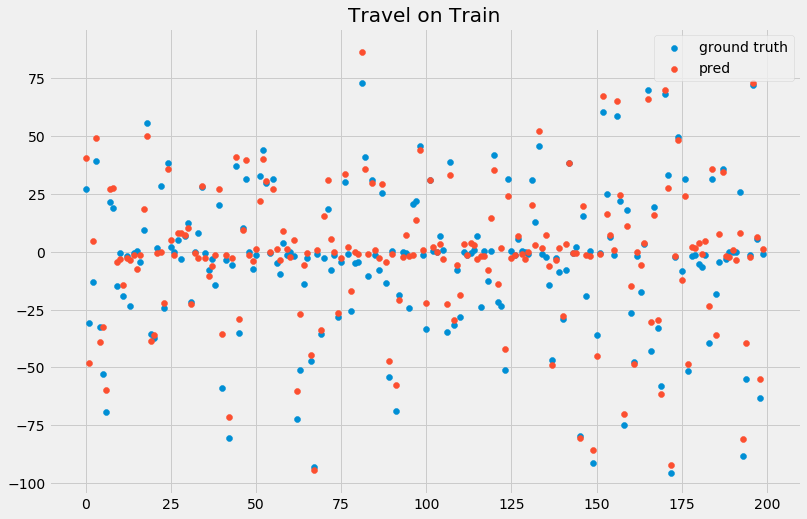

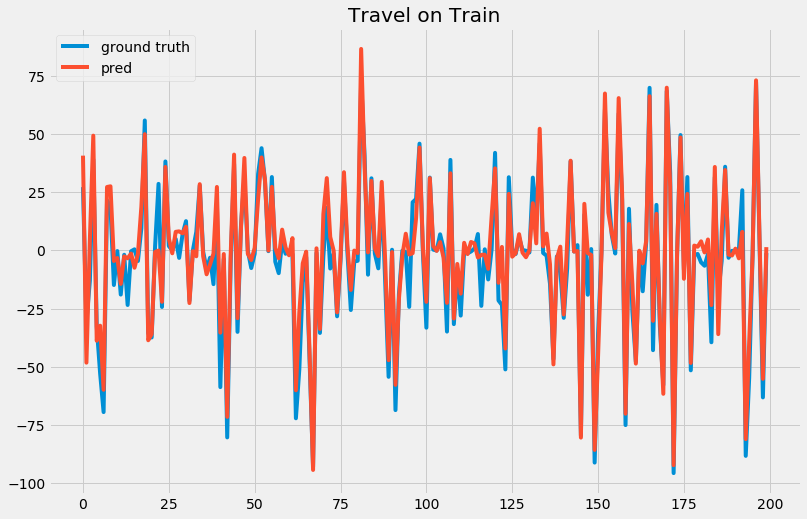

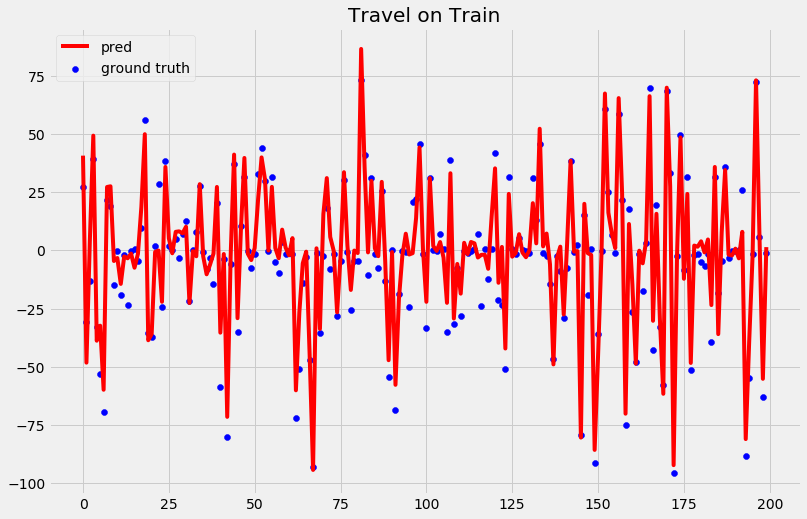

In [588]:
visualize(title = 'Travel on Train',actual_= actual_travel_train,predicted_=predicted_travel_train,scope = [800,1000])

## `Velocity`

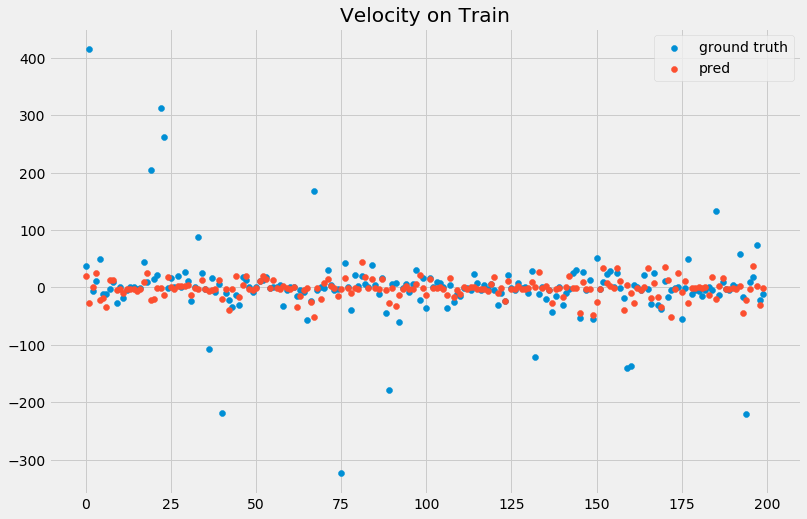

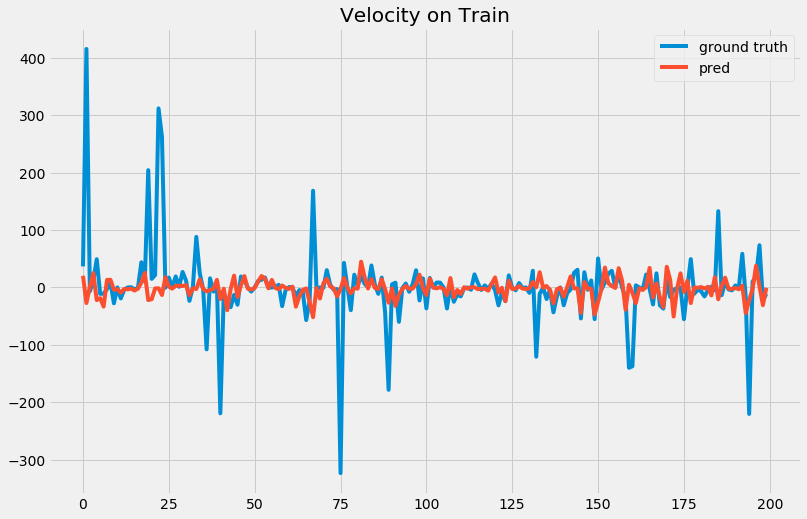

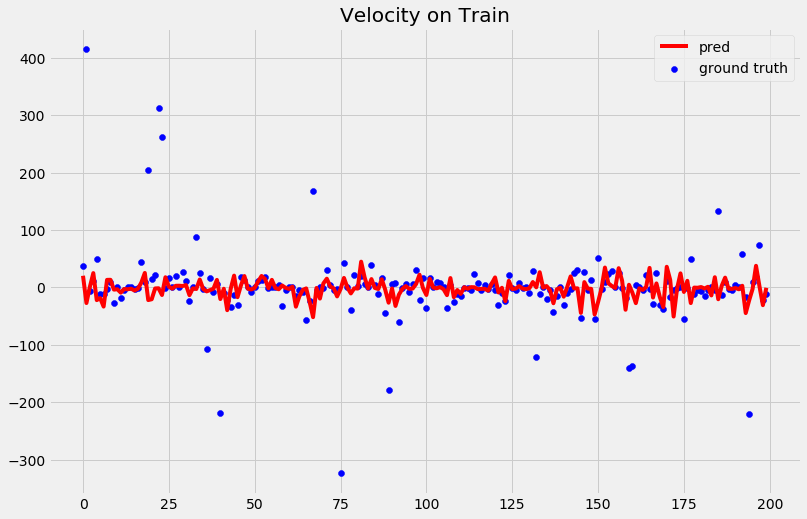

In [589]:
visualize(title = 'Velocity on Train',actual_= actual_velocity_train,predicted_=predicted_velocity_train,scope = [800,1000])

## `Travel distance change`

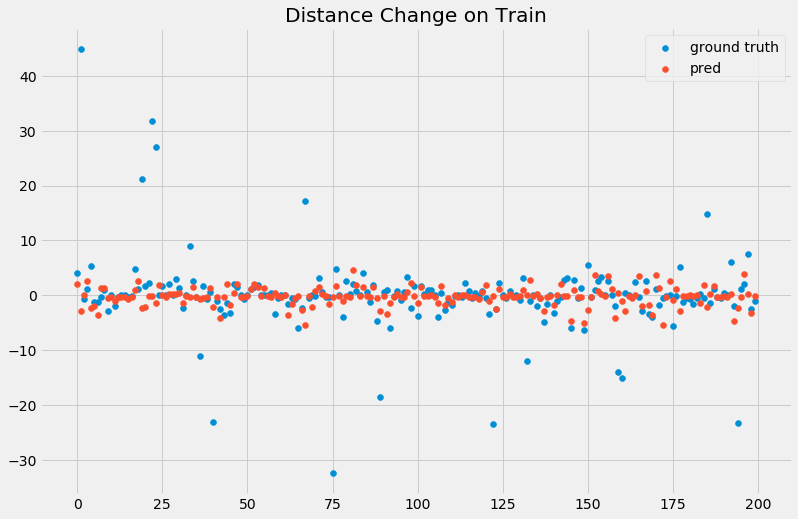

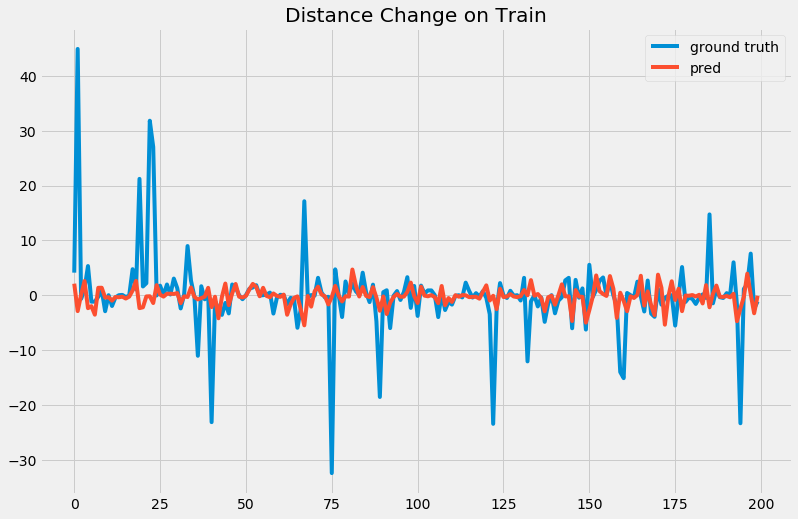

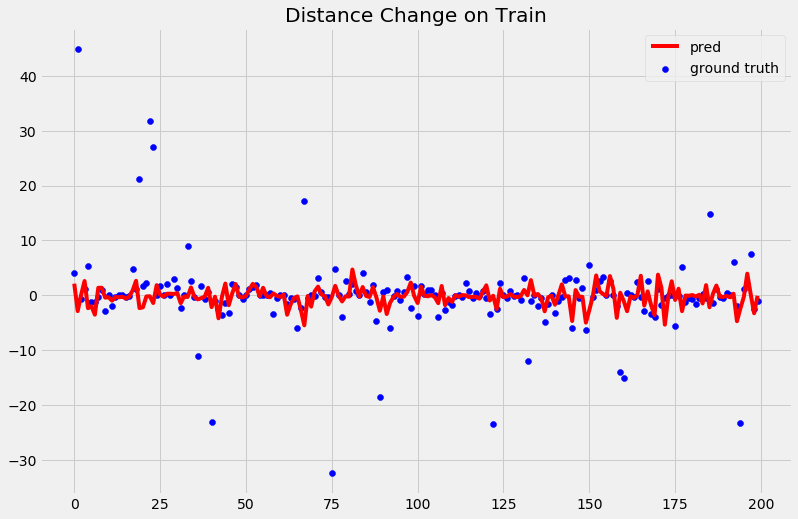

In [590]:
visualize(title = 'Distance Change on Train',actual_= actual_distance_change_train,
          predicted_=predicted_distance_change_train,scope = [800,1000])

In [591]:
actual_distance_change_train == actual_velocity_train

False

> ## Testing data fit visualizations (Unseen data)

In [592]:
#pred
actual_travel_test = []
predicted_travel_test = []

actual_velocity_test = []
predicted_velocity_test = []

actual_distance_change_test = []
predicted_distance_change_test= []


for i in range(len(xtest)):

    actual = sc.inverse_transform(np.reshape(ytest[i],(1,-1)))
    predicted = sc.inverse_transform(model.predict(np.reshape(xtest[i],(1,-1))))
    
    actual_velocity_test.append(actual[0][0])
    predicted_velocity_test.append(predicted[0][0])
    
    actual_travel_test.append(actual[0][1])
    predicted_travel_test.append(predicted[0][1])
    
    actual_distance_change_test.append(actual[0][2])
    predicted_distance_change_test.append(predicted[0][2])
    
    
    print('act dist: ',round(actual[0][1],2),' pred:',round(predicted[0][1],2),'       act vel: ',
          round(actual[0][0],2),' pred: ',round(predicted[0][0],2),
         '      act chng: ',round(actual[0][2],2),' pred:',round(predicted[0][2],2))

    

    


act dist:  16.11  pred: 13.47        act vel:  12.4  pred:  5.84       act chng:  1.34  pred: 0.57
act dist:  -0.56  pred: 2.5        act vel:  10.26  pred:  -0.02       act chng:  1.14  pred: -0.05
act dist:  31.4  pred: 41.43        act vel:  4.1  pred:  20.78       act chng:  0.42  pred: 2.14
act dist:  -0.47  pred: -1.24        act vel:  -1.08  pred:  -2.02       act chng:  -0.12  pred: -0.26
act dist:  -0.1  pred: -4.38        act vel:  0.99  pred:  -3.7       act chng:  0.1  pred: -0.44
act dist:  45.38  pred: 37.47        act vel:  58.92  pred:  18.66       act chng:  6.11  pred: 1.92
act dist:  -0.25  pred: 0.23        act vel:  3.77  pred:  -1.23       act chng:  0.39  pred: -0.18
act dist:  48.56  pred: 38.67        act vel:  48.39  pred:  19.3       act chng:  4.92  pred: 1.99
act dist:  -3.22  pred: -0.73        act vel:  -34.21  pred:  -1.75       act chng:  -3.44  pred: -0.23
act dist:  28.1  pred: 20.51        act vel:  40.77  pred:  9.6       act chng:  4.52  pred: 0.96

act dist:  0.04  pred: -0.57        act vel:  -1.09  pred:  -1.66       act chng:  -0.11  pred: -0.22
act dist:  -80.85  pred: -77.77        act vel:  -23.69  pred:  -42.9       act chng:  -2.64  pred: -4.56
act dist:  -9.48  pred: -2.36        act vel:  0.0  pred:  -2.62       act chng:  0.0  pred: -0.32
act dist:  18.36  pred: 17.26        act vel:  21.07  pred:  7.86       act chng:  2.25  pred: 0.78
act dist:  0.16  pred: -0.79        act vel:  0.0  pred:  -1.78       act chng:  0.0  pred: -0.23
act dist:  44.05  pred: 49.93        act vel:  0.92  pred:  25.32       act chng:  0.1  pred: 2.62
act dist:  -58.84  pred: -59.08        act vel:  -9.23  pred:  -32.92       act chng:  -1.0  pred: -3.51
act dist:  -10.74  pred: -2.27        act vel:  12.13  pred:  -2.57       act chng:  1.27  pred: -0.32
act dist:  -0.98  pred: 2.33        act vel:  16.1  pred:  -0.11       act chng:  1.65  pred: -0.06
act dist:  -3.34  pred: -7.18        act vel:  149.53  pred:  -5.19       act chng:  16.

act dist:  4.19  pred: 6.99        act vel:  12.75  pred:  2.38       act chng:  1.39  pred: 0.2
act dist:  21.07  pred: 1.99        act vel:  8.77  pred:  -0.29       act chng:  21.07  pred: -0.08
act dist:  -16.14  pred: 1.51        act vel:  -6.95  pred:  -0.55       act chng:  -16.14  pred: -0.1
act dist:  0.42  pred: -2.15        act vel:  -0.3  pred:  -2.5       act chng:  -0.03  pred: -0.31
act dist:  -1.9  pred: -0.35        act vel:  -0.58  pred:  -1.54       act chng:  -0.06  pred: -0.21
act dist:  38.23  pred: 35.97        act vel:  0.0  pred:  17.86       act chng:  0.0  pred: 1.83
act dist:  -0.75  pred: -2.24        act vel:  1.09  pred:  -2.55       act chng:  0.12  pred: -0.31
act dist:  -9.57  pred: -2.8        act vel:  0.1  pred:  -2.85       act chng:  0.01  pred: -0.35
act dist:  -29.76  pred: 0.28        act vel:  -173.24  pred:  -1.21       act chng:  -17.99  pred: -0.17
act dist:  38.3  pred: 32.31        act vel:  6.54  pred:  15.9       act chng:  0.68  pred: 

act dist:  37.93  pred: 30.63        act vel:  19.35  pred:  15.01       act chng:  1.96  pred: 1.53
act dist:  59.82  pred: 18.07        act vel:  447.04  pred:  8.3       act chng:  45.78  pred: 0.83
act dist:  27.48  pred: 14.96        act vel:  8.73  pred:  6.64       act chng:  0.92  pred: 0.65
act dist:  -11.16  pred: 4.19        act vel:  -21.17  pred:  0.88       act chng:  -2.19  pred: 0.05
act dist:  -12.01  pred: -3.02        act vel:  -19.5  pred:  -2.97       act chng:  -2.11  pred: -0.36
act dist:  -0.03  pred: 0.74        act vel:  -0.01  pred:  -0.96       act chng:  -0.03  pred: -0.15
act dist:  48.98  pred: 33.13        act vel:  3.04  pred:  16.34       act chng:  0.31  pred: 1.67
act dist:  -52.37  pred: -37.15        act vel:  -345.89  pred:  -21.2       act chng:  -37.2  pred: -2.28
act dist:  -29.84  pred: -27.5        act vel:  -35.47  pred:  -16.05       act chng:  -3.89  pred: -1.73
act dist:  68.61  pred: 69.7        act vel:  51.59  pred:  35.88       act ch

act dist:  8.98  pred: 4.02        act vel:  101.91  pred:  0.79       act chng:  10.37  pred: 0.04
act dist:  -2.46  pred: 3.2        act vel:  15.81  pred:  0.35       act chng:  1.67  pred: -0.01
act dist:  -9.11  pred: 15.86        act vel:  11.91  pred:  7.12       act chng:  1.33  pred: 0.7
act dist:  -47.15  pred: -40.54        act vel:  -64.05  pred:  -23.01       act chng:  -6.85  pred: -2.47
act dist:  53.34  pred: 49.58        act vel:  25.2  pred:  25.13       act chng:  2.74  pred: 2.6
act dist:  -31.25  pred: -24.64        act vel:  -54.55  pred:  -14.52       act chng:  -5.7  pred: -1.57
act dist:  0.07  pred: -3.87        act vel:  0.0  pred:  -3.42       act chng:  0.0  pred: -0.41
act dist:  4.41  pred: -1.27        act vel:  263.46  pred:  -2.03       act chng:  28.45  pred: -0.26
act dist:  17.41  pred: 2.33        act vel:  166.6  pred:  -0.11       act chng:  17.92  pred: -0.06
act dist:  -5.06  pred: -5.94        act vel:  -38.65  pred:  -4.53       act chng:  -4

act dist:  -0.54  pred: -3.53        act vel:  -6.02  pred:  -3.24       act chng:  -0.66  pred: -0.39
act dist:  -1.93  pred: -1.51        act vel:  -4.56  pred:  -2.16       act chng:  -0.51  pred: -0.27
act dist:  -0.48  pred: 6.87        act vel:  -0.18  pred:  2.32       act chng:  -0.02  pred: 0.2
act dist:  -63.61  pred: -67.88        act vel:  -24.17  pred:  -37.62       act chng:  -2.7  pred: -4.0
act dist:  -1.46  pred: -3.17        act vel:  -0.99  pred:  -3.05       act chng:  -0.11  pred: -0.37
act dist:  -4.03  pred: -4.32        act vel:  -25.38  pred:  -3.66       act chng:  -2.67  pred: -0.43
act dist:  76.97  pred: 84.45        act vel:  -46.44  pred:  43.76       act chng:  -5.08  pred: 4.56
act dist:  20.92  pred: 23.52        act vel:  50.19  pred:  11.21       act chng:  5.29  pred: 1.13
act dist:  15.08  pred: -3.0        act vel:  167.69  pred:  -2.96       act chng:  16.98  pred: -0.36
act dist:  50.6  pred: 47.4        act vel:  26.59  pred:  23.97       act c

act dist:  43.95  pred: 49.22        act vel:  0.0  pred:  24.94       act chng:  0.0  pred: 2.58
act dist:  -3.56  pred: -8.39        act vel:  -27.83  pred:  -5.84       act chng:  -3.04  pred: -0.66
act dist:  -37.08  pred: -33.21        act vel:  65.34  pred:  -19.1       act chng:  6.54  pred: -2.06
act dist:  -1.09  pred: 7.63        act vel:  -4.35  pred:  2.72       act chng:  -0.48  pred: 0.24
act dist:  62.01  pred: 58.66        act vel:  33.88  pred:  29.98       act chng:  3.42  pred: 3.11
act dist:  -0.42  pred: 0.92        act vel:  -0.2  pred:  -0.87       act chng:  -0.42  pred: -0.14
act dist:  -13.38  pred: -7.05        act vel:  -7.55  pred:  -5.12       act chng:  -0.78  pred: -0.58
act dist:  -44.78  pred: -46.57        act vel:  -49.14  pred:  -26.23       act chng:  -5.49  pred: -2.81
act dist:  -1.07  pred: 6.18        act vel:  0.72  pred:  1.95       act chng:  0.08  pred: 0.16
act dist:  -0.37  pred: -2.34        act vel:  1.08  pred:  -2.6       act chng:  0

act dist:  -0.46  pred: 0.17        act vel:  11.21  pred:  -1.27       act chng:  1.24  pred: -0.18
act dist:  -14.18  pred: -2.87        act vel:  -3.67  pred:  -2.89       act chng:  -0.38  pred: -0.35
act dist:  48.44  pred: 55.69        act vel:  7.05  pred:  28.39       act chng:  0.71  pred: 2.94
act dist:  1.84  pred: -0.64        act vel:  3.2  pred:  -1.7       act chng:  0.34  pred: -0.22
act dist:  -1.88  pred: 1.49        act vel:  4.1  pred:  -0.56       act chng:  0.42  pred: -0.1
act dist:  -86.37  pred: -80.67        act vel:  -21.38  pred:  -44.45       act chng:  -2.43  pred: -4.72
act dist:  1.58  pred: 2.16        act vel:  30.91  pred:  -0.2       act chng:  3.23  pred: -0.07
act dist:  -0.64  pred: 0.25        act vel:  5.49  pred:  -1.22       act chng:  0.56  pred: -0.17
act dist:  0.12  pred: -0.72        act vel:  -0.2  pred:  -1.74       act chng:  -0.02  pred: -0.23
act dist:  49.96  pred: 48.58        act vel:  -2.49  pred:  24.6       act chng:  -0.25  pr

act dist:  11.98  pred: 6.25        act vel:  5.87  pred:  1.98       act chng:  0.65  pred: 0.16
act dist:  44.36  pred: 46.54        act vel:  -0.98  pred:  23.51       act chng:  -0.1  pred: 2.43
act dist:  0.22  pred: -1.36        act vel:  5.69  pred:  -2.08       act chng:  0.57  pred: -0.26
act dist:  -0.31  pred: 2.95        act vel:  7.48  pred:  0.22       act chng:  0.8  pred: -0.02
act dist:  -16.4  pred: -11.29        act vel:  0.67  pred:  -7.39       act chng:  0.07  pred: -0.82
act dist:  7.74  pred: 0.13        act vel:  -3.13  pred:  -1.29       act chng:  -0.32  pred: -0.18
act dist:  -59.61  pred: -61.92        act vel:  -16.32  pred:  -34.43       act chng:  -1.75  pred: -3.67
act dist:  -2.01  pred: -1.17        act vel:  -11.33  pred:  -1.98       act chng:  -1.26  pred: -0.25
act dist:  35.78  pred: 28.58        act vel:  -65.73  pred:  13.91       act chng:  -7.09  pred: 1.42
act dist:  76.37  pred: 68.32        act vel:  -10.94  pred:  35.14       act chng:  -

act dist:  0.03  pred: -1.06        act vel:  5.0  pred:  -1.92       act chng:  0.51  pred: -0.25
act dist:  12.82  pred: 20.9        act vel:  -33.16  pred:  9.81       act chng:  -3.65  pred: 0.99
act dist:  -38.67  pred: -37.94        act vel:  -15.98  pred:  -21.62       act chng:  -1.73  pred: -2.32
act dist:  -37.92  pred: -36.38        act vel:  -9.87  pred:  -20.79       act chng:  -1.0  pred: -2.23
act dist:  0.85  pred: -3.73        act vel:  -0.2  pred:  -3.35       act chng:  -0.02  pred: -0.4
act dist:  -8.14  pred: 2.69        act vel:  -7.44  pred:  0.08       act chng:  -0.76  pred: -0.04
act dist:  -84.91  pred: -82.86        act vel:  -48.93  pred:  -45.62       act chng:  -5.39  pred: -4.85
act dist:  -1.11  pred: 2.15        act vel:  3.1  pred:  -0.2       act chng:  0.34  pred: -0.07
act dist:  4.29  pred: 4.61        act vel:  14.92  pred:  1.11       act chng:  1.5  pred: 0.07
act dist:  -0.85  pred: -0.62        act vel:  1.07  pred:  -1.69       act chng:  0.

### R2 fit evaluation on test data

In [593]:
print('travel fit coefficient          :',r2_score(actual_travel_test,predicted_travel_test))
print('velocity fit coefficient        :',r2_score(actual_velocity_test,predicted_velocity_test))
print('distance change fit coefficient :',r2_score(actual_distance_change_test,predicted_distance_change_test))

travel fit coefficient          : 0.8685467940650659
velocity fit coefficient        : 0.0018937388677212619
distance change fit coefficient : 0.0026416246507742214


## `Travel Visualization` on Test
-----------------------

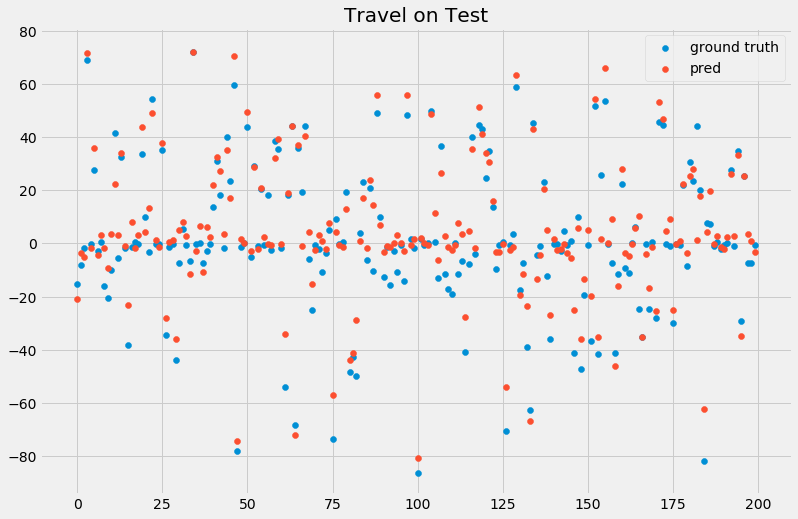

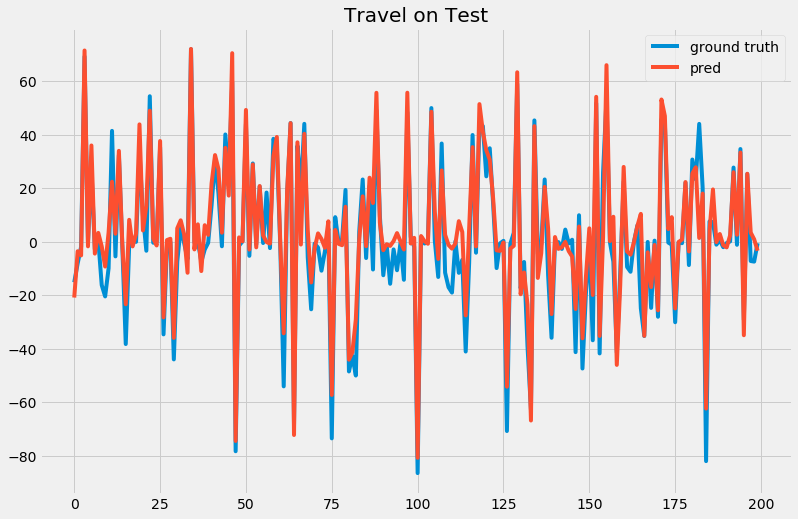

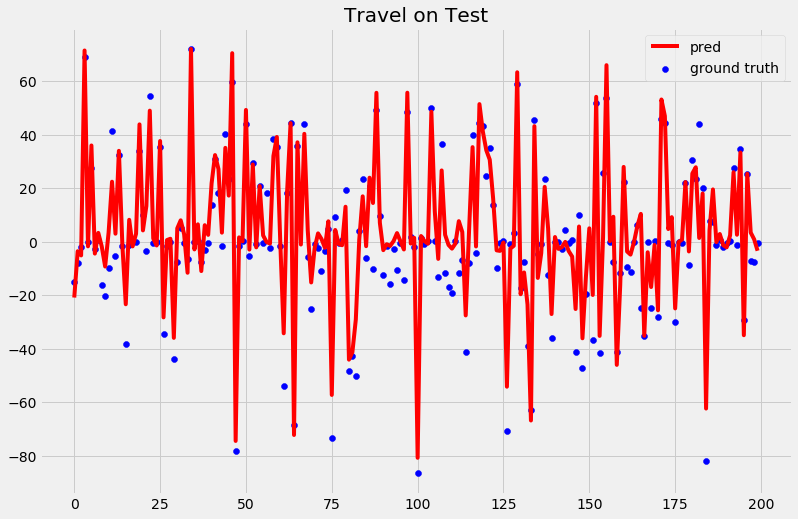

In [594]:
visualize(title = 'Travel on Test',actual_= actual_travel_test,
          predicted_=predicted_travel_test,scope = [800,1000])

## `Velocity` on Test

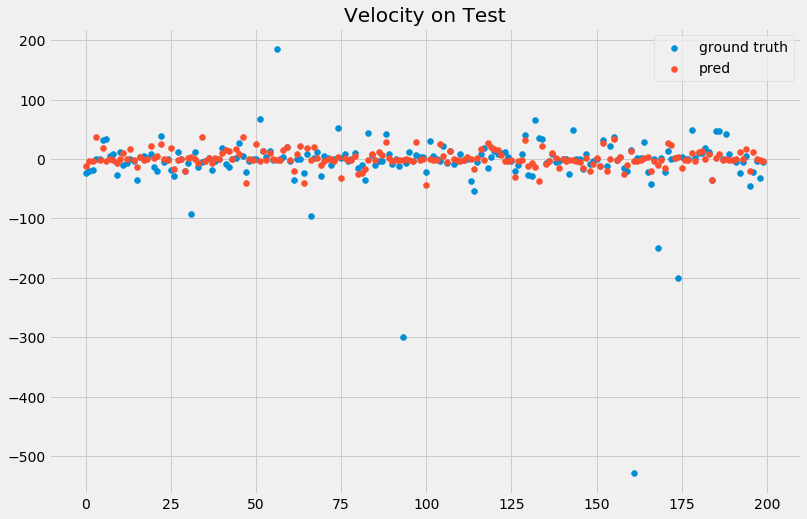

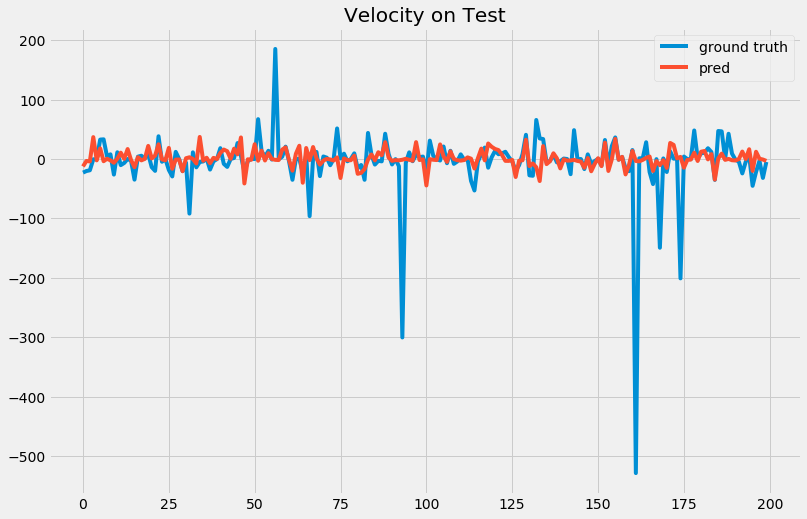

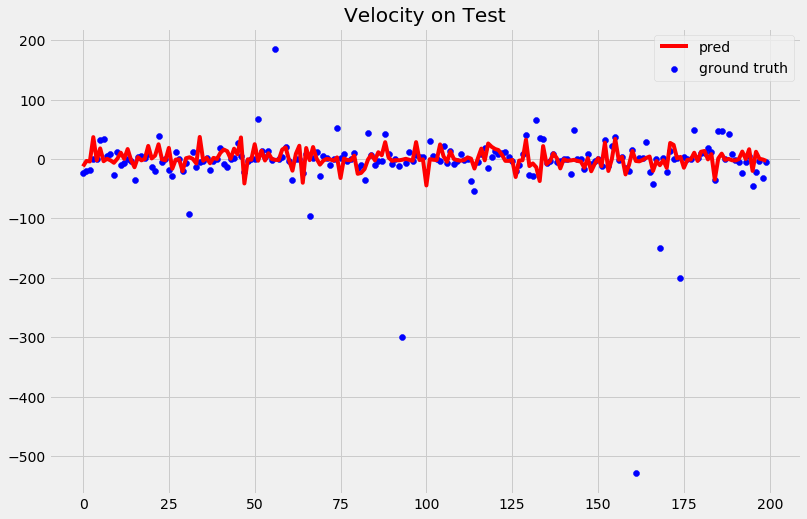

In [595]:
visualize(title = 'Velocity on Test',actual_= actual_velocity_test,predicted_=predicted_velocity_test,scope = [800,1000])

## `Travel distance change` on Test

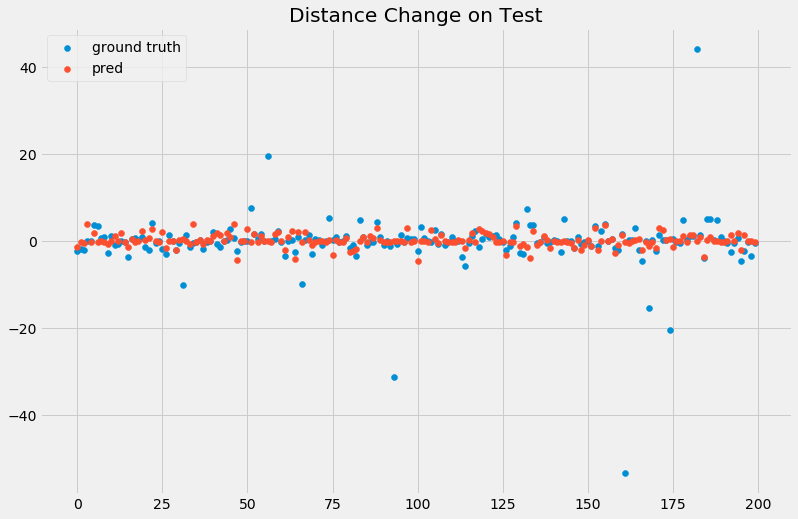

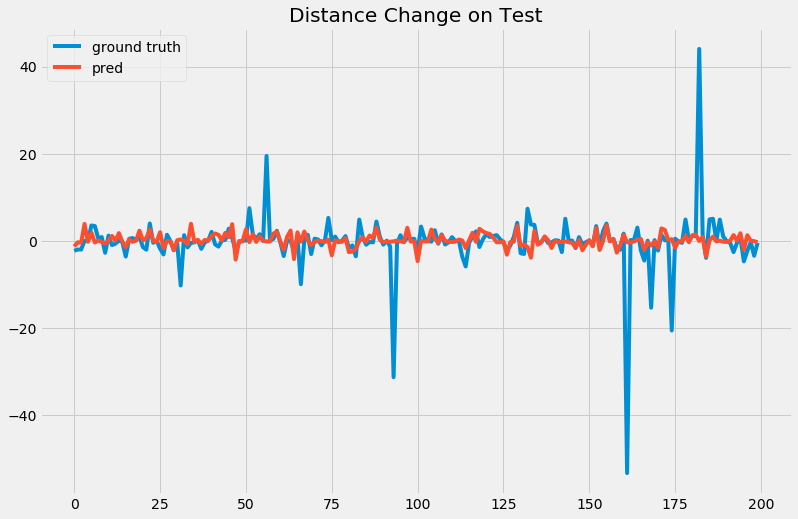

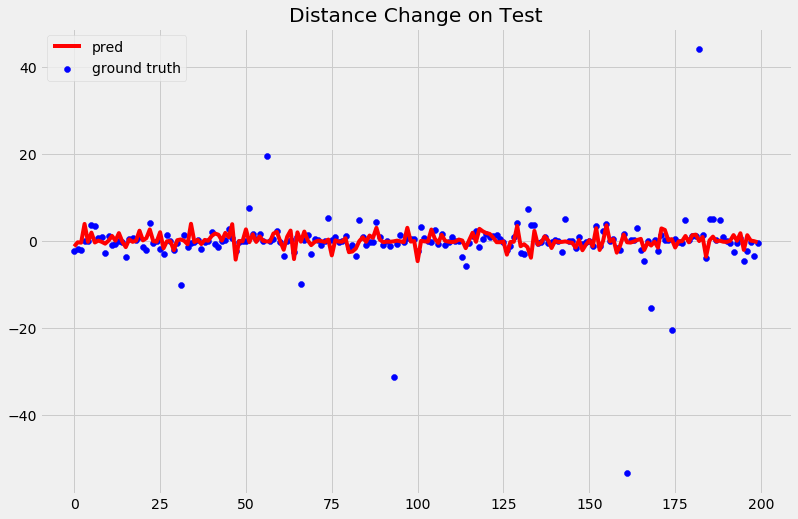

In [596]:
visualize(title = 'Distance Change on Test',actual_= actual_distance_change_test,
          predicted_=predicted_distance_change_test,scope = [800,1000])

In [597]:
train_predictions = sc.inverse_transform(model.predict(xtrain))
train_predictions

array([[-1.09904947e+01, -1.80354843e+01, -1.20257020e+00],
       [-1.36363518e+00, -1.49381654e-02, -1.89465210e-01],
       [ 9.78371334e+00,  2.08518295e+01,  9.83654618e-01],
       ...,
       [-9.64085996e-01,  7.32972682e-01, -1.47416875e-01],
       [-1.41945338e+00, -1.19449876e-01, -1.95341870e-01],
       [-1.32851183e+00,  5.07707857e-02, -1.85768604e-01]], dtype=float32)

In [598]:
train_actual = sc.inverse_transform(ytrain)
train_actual

array([[ 25.15115894, -23.1216    ,   2.6       ],
       [ -5.55023587,  -1.5791    ,  -0.6       ],
       [ 29.23271151,  15.8333    ,   3.22      ],
       ...,
       [-13.04140657,  -1.7248    ,  -1.39      ],
       [ -0.96612452,  -0.6842    ,  -0.1       ],
       [ 17.90346063,  -1.2434    ,   1.99      ]])

In [599]:
'''TEST PREDICTIONS'''

test_predictions = sc.inverse_transform(model.predict(xtest))
test_predictions

array([[ 5.8399582e+00,  1.3469468e+01,  5.6862360e-01],
       [-1.8640125e-02,  2.5027978e+00, -4.7919918e-02],
       [ 2.0775480e+01,  4.1427376e+01,  2.1404083e+00],
       ...,
       [-8.7153667e-01,  9.0621382e-01, -1.3767661e-01],
       [-1.5132623e+01, -2.5789139e+01, -1.6384810e+00],
       [ 4.3815203e-02,  2.6196573e+00, -4.1348170e-02]], dtype=float32)

In [600]:
test_actual = sc.inverse_transform(ytest)
test_actual

array([[ 12.39514407,  16.1139    ,   1.34      ],
       [ 10.25581386,  -0.5609    ,   1.14      ],
       [  4.09666678,  31.4002    ,   0.42      ],
       ...,
       [ -6.12953402, -15.1265    , -15.1265    ],
       [ 20.22989948, -27.5216    ,   2.13      ],
       [ -6.08922455,  -2.2802    ,  -0.66      ]])






# !!!======================  Working here  =======================!!!

# Prediction Techniques
> Endeavour to run different kinds of predictions as a result of different time samples features
>
>Po to P40 because there are 40 datapoints were sampled per episode

In [601]:
#function returns all rows (datapoints) of a particular sampled timed-feature
#dataframe must not be shuffled as it emlpoys the use of the original indices
def getSampleTimedRows(dataframe,sample_timed_feature = 0,samples_per_episode = 40):
    #samples per episode referes to the number of samples
    #sampled per episode when callecting the data

    rows = []
    for i in range(sample_timed_feature,dataframe.shape[0],samples_per_episode):
        rows.append(dataframe.iloc[i])
    return pd.DataFrame(rows)
    
        
    

In [602]:
def investigate_time_sampled_features():
    
    v_r2 =[] 
    travel_r2 = []
    change_r2 = []
    x = []
    
    for tsf in range(1,41):
        P1 = getSampleTimedRows(finaldf,sample_timed_feature=tsf)


        Xp1 = P1.copy().drop(['v(t)','travel_dist','d(travel_dist)'],axis = 1)
        Yp1 = P1[['v(t)','travel_dist','d(travel_dist)']]

        Xp1_scaled = sc.fit_transform(Xp1)
        Yp1_scaled = sc.fit_transform(Yp1)
        Xp1_pred = sc.inverse_transform(model.predict(Xp1_scaled))
       
        v_pred = []
        travel_pred = []
        t_change_pred = []
        v_a = []
        travel_a = []
        t_change_a= []

        for i in Xp1_pred:
            v_pred.append(i[0])
            travel_pred.append(i[1])
            t_change_pred.append(i[2])

        for i in np.array(Yp1):
            v_a.append(i[0])
            travel_a.append(i[1])
            t_change_a.append(i[2])

        travel_r2.append(r2_score(travel_a,travel_pred))
        v_r2.append(r2_score(v_a,v_pred))
        change_r2.append(r2_score(t_change_a,t_change_pred))
        x.append(tsf)
        #print(tsf)
        
    plt.figure(figsize=(10,8))
    plt.plot(x,travel_r2)
    plt.plot(x,v_r2)
    plt.plot(x,change_r2)
    plt.xlabel('time sampled feature')
    plt.ylabel('r2_score')
    plt.legend(['travel','velocity','change'])
    plt.show()
    
    print('Best TIme Sampled Features R2score')
    print('travel        :',max(travel_r2),'     Best Feature: ',travel_r2.index(max(travel_r2))+1)
    print('velocity      :',max(v_r2),'     Best Feature: ',v_r2.index(max(v_r2))+1)
    print('travel change :',max(change_r2),'     Best Feature: ',change_r2.index(max(change_r2))+1)

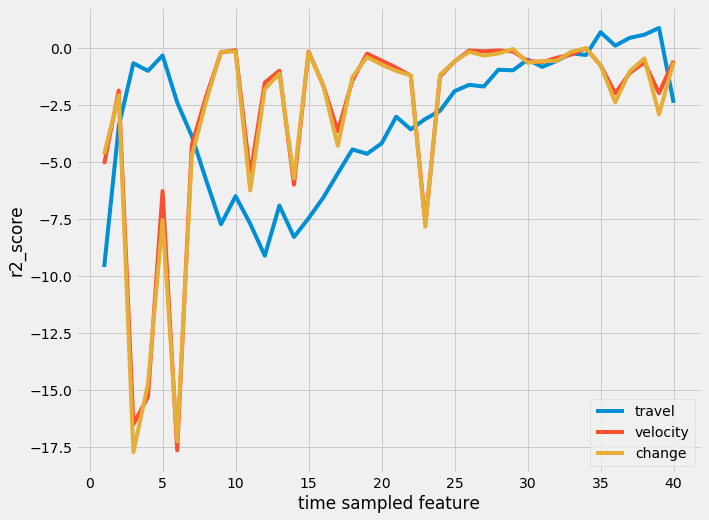

Best TIme Sampled Features R2score
travel        : 0.887751451967954      Best Feature:  39
velocity      : -0.0008512071439890079      Best Feature:  34
travel change : 0.0002695082397035087      Best Feature:  34


In [603]:
investigate_time_sampled_features()

In [604]:
a = [1,2,3,4,5]
a.index(max(a))

4

In [605]:
'''plt.figure(figsize=(16,10))
plt.title('travel')
plt.plot(list(range(len(travel_a))),travel_a,color = 'r')
plt.plot(list(range(len(travel_pred))),travel_pred)

plt.legend(['gt','pred'])
plt.show()

plt.figure(figsize=(16,10))
plt.title('V')
plt.plot(list(range(len(v_a))),v_a,color = 'r')
plt.plot(list(range(len(v_pred))),v_pred)

plt.legend(['gt','pred'])
plt.show()

plt.figure(figsize=(16,10))
plt.title('C')
plt.plot(list(range(len(t_change_a))),t_change_a,color = 'r')
plt.plot(list(range(len(t_change_pred))),t_change_pred)

plt.legend(['gt','pred'])
plt.show()
'''

"plt.figure(figsize=(16,10))\nplt.title('travel')\nplt.plot(list(range(len(travel_a))),travel_a,color = 'r')\nplt.plot(list(range(len(travel_pred))),travel_pred)\n\nplt.legend(['gt','pred'])\nplt.show()\n\nplt.figure(figsize=(16,10))\nplt.title('V')\nplt.plot(list(range(len(v_a))),v_a,color = 'r')\nplt.plot(list(range(len(v_pred))),v_pred)\n\nplt.legend(['gt','pred'])\nplt.show()\n\nplt.figure(figsize=(16,10))\nplt.title('C')\nplt.plot(list(range(len(t_change_a))),t_change_a,color = 'r')\nplt.plot(list(range(len(t_change_pred))),t_change_pred)\n\nplt.legend(['gt','pred'])\nplt.show()\n"

# Build Separate Models
# :( model is not learning for some reason ):
> # Investigate the effect of shared weights on the 3 outputs
> ## Reason :
>The first model above was trained to predict all 3 variables `velocity,intantaneous change in distance travelled and distcance travelled`. Howver, the coefficient of determination, `R2 score` `velocity` and `travel distance change` was -ve. This means that the model did not do any better than a straight line drawn though the mean of all the values.
> # `Assumption`
>The shared weights on the 3 separate output variable prevented the ANN from fitting better and predicting better for these output variables
> `Separate the ANNs to investigate this effect`

In [606]:
#separate y 
Y_vel = Y['v(t)'] 
Y_dist = Y['travel_dist']
Y_chng = Y['d(travel_dist)']
X

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,dz32,dz33,dz34,dz35,dz36,dz37,dz38,dz39,travel_time,dt
0,2.738967,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.371837,2.371803
1,2.738967,2.786851,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.473090,0.101271
2,2.738967,2.786851,2.628833,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.573853,0.100762
3,2.738967,2.786851,2.628833,2.760515,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.674714,0.100860
4,2.738967,2.786851,2.628833,2.760515,2.60968,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.775668,0.100954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,2.274492,2.379836,2.372654,2.315193,2.30801,2.339135,2.327164,2.346318,2.358289,2.396596,...,-0.806846,-1.869871,1.422156,0.684742,0.000000,0.000000,0.000000,0.000000,5.750833,0.100359
36,2.274492,2.379836,2.372654,2.315193,2.30801,2.339135,2.327164,2.346318,2.358289,2.396596,...,-0.806846,-1.869871,1.422156,0.684742,0.648829,0.000000,0.000000,0.000000,5.860174,0.109342
37,2.274492,2.379836,2.372654,2.315193,2.30801,2.339135,2.327164,2.346318,2.358289,2.396596,...,-0.806846,-1.869871,1.422156,0.684742,0.648829,-1.565808,0.000000,0.000000,5.969007,0.108834
38,2.274492,2.379836,2.372654,2.315193,2.30801,2.339135,2.327164,2.346318,2.358289,2.396596,...,-0.806846,-1.869871,1.422156,0.684742,0.648829,-1.565808,1.319205,0.000000,6.077279,0.108271


In [607]:
#prepocess and reshape  
sc1 = MinMaxScaler()
Y_vel = np.array(Y_vel)
Y_dist = np.array(Y_dist)
Y_chng = np.array(Y_chng)
Y_vel = np.reshape(Y_vel,(-1,1))
Y_dist = np.reshape(Y_dist,(-1,1))
Y_chng = np.reshape(Y_chng,(-1,1))

#scale outputs
Y_vel_sc = sc1.fit_transform(Y_vel)
Y_dist_sc = sc1.fit_transform(Y_dist)
Y_chng_sc = sc1.fit_transform(Y_chng)
Xsc = sc1.fit_transform(X)

In [608]:
#velocity
xvtrain,xvtest,yvtrain,yvtest = train_test_split(Xsc,Y_vel_sc,test_size = 0.3)
#travel
xttrain,xttest,yttrain,yttest = train_test_split(Xsc,Y_dist_sc,test_size = 0.3)
#change
xctrain,xctest,yctrain,yctest = train_test_split(Xsc,Y_chng_sc,test_size = 0.3)

In [629]:
from keras.layers import LeakyReLU

In [646]:
def ANN(inshape,outshape):
    submodel = Sequential()
    submodel.add(Dense(units = inshape,input_dim = inshape,activation ='relu' ))
    submodel.add(Dense(units = 512,activation = 'relu'))
    submodel.add(Dense(units = 256,activation = 'relu'))
    submode.add(LeakyReLU())
    submodel.add(Dense(units = 128,activation = 'relu'))
    submodel.add(Dense(units = 64,activation = 'relu'))
    submodel.add(Dense(units = 32,activation = 'relu'))
    submodel.add(LeakyReLU())
    submodel.add(Dense(units = 16,activation = 'relu'))
    submodel.add(Dense(units = 8,activation = 'relu'))
    submodel.add(Dense(units = 3,activation = 'relu'))
    submodel.add(LeakyReLU())
    submodel.add(Dense(units = outshape,activation = 'linear'))
    submodel.compile(optimizer = 'Adam',metrics = ['mse','mae',RootMeanSquaredError()],loss ='mse' )
    return submodel

In [647]:
Tmodel = ANN(xttrain.shape[1],1)
Cmodel = ANN(xctrain.shape[1],1)
Vmodel = ANN(xvtrain.shape[1],1)

In [649]:
hist = Vmodel.fit(xttrain,yttrain,validation_data=(xttest,yttest),epochs = 50,
                callbacks = [ModelCheckpoint(filepath = 'tmodel.hdf5',
                                            monitor = 'val_root_mean_squared_error',mode = 'min',save_best_only = True)])

Train on 2800 samples, validate on 1200 samples
Epoch 1/50
2800/2800 [==============================] - 1s 289us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0333 - root_mean_squared_error: 0.0479 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0308 - val_root_mean_squared_error: 0.0456
Epoch 2/50
2800/2800 [==============================] - 1s 480us/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0297 - root_mean_squared_error: 0.0447 - val_loss: 0.0022 - val_mse: 0.0022 - val_mae: 0.0310 - val_root_mean_squared_error: 0.0465
Epoch 3/50
2800/2800 [==============================] - 1s 296us/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0291 - root_mean_squared_error: 0.0440 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0304 - val_root_mean_squared_error: 0.0455
Epoch 4/50
2800/2800 [==============================] - 2s 770us/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0285 - root_mean_squared_error: 0.0436 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0407 - val_root_mean_squared_error:

Epoch 35/50
2800/2800 [==============================] - 1s 431us/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0287 - root_mean_squared_error: 0.0435 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0291 - val_root_mean_squared_error: 0.0453
Epoch 36/50
2800/2800 [==============================] - 1s 401us/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0271 - root_mean_squared_error: 0.0419 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0300 - val_root_mean_squared_error: 0.0457
Epoch 37/50
2800/2800 [==============================] - 1s 398us/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0293 - root_mean_squared_error: 0.0441 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0269 - val_root_mean_squared_error: 0.0433
Epoch 38/50
2800/2800 [==============================] - 2s 694us/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0287 - root_mean_squared_error: 0.0434 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0369 - val_root_mean_squared_error: 0.0500
Epoch 39/50
2800/2800 [=============

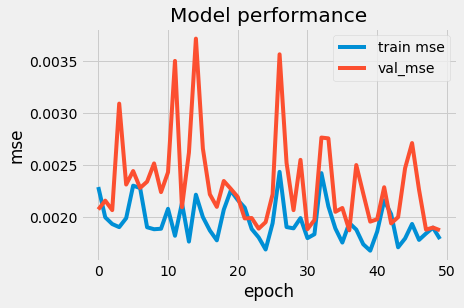

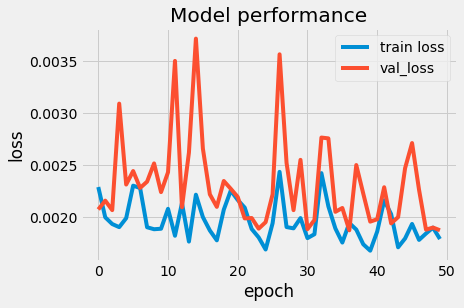

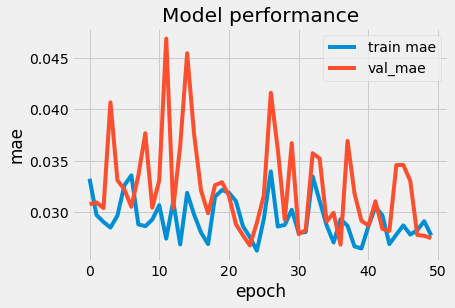

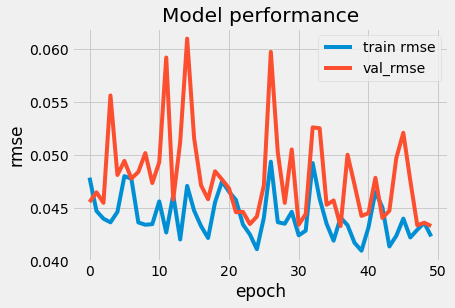

In [650]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Model performance')
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.legend(['train mse','val_mse'])
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

plt.figure()
plt.title('Model performance')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train loss','val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.title('Model performance')
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.legend(['train mae','val_mae'])
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

plt.figure()
plt.title('Model performance')
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.legend(['train rmse','val_rmse'])
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.show()

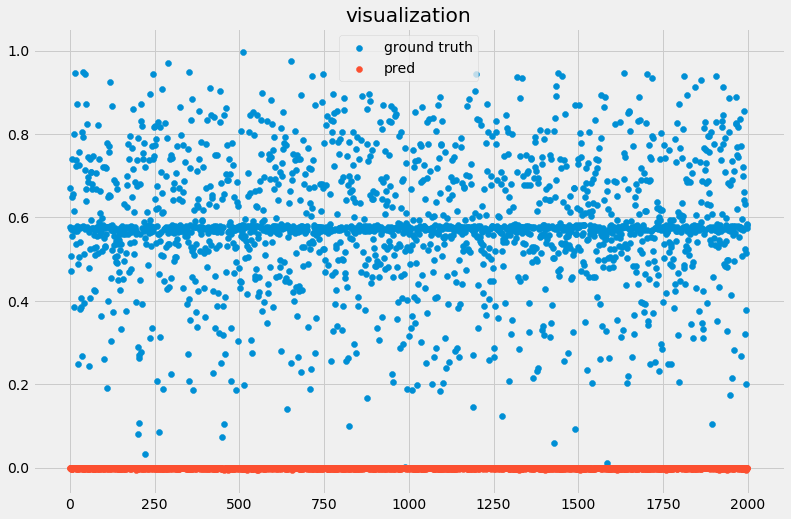

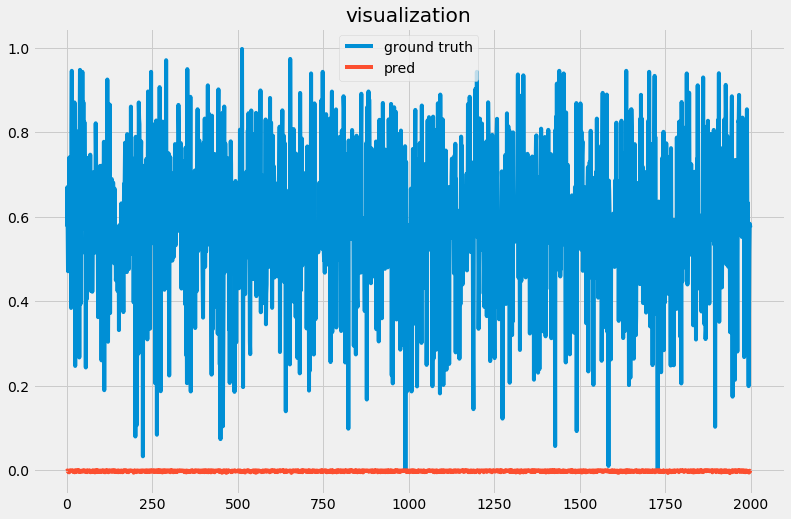

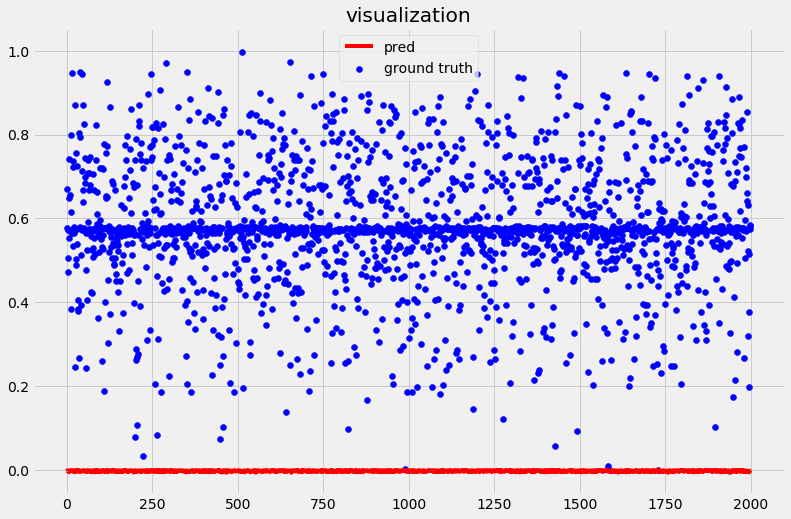

-15.628669351115736

In [651]:
#plt.figure(figsize= (16,8))
#plt.plot(list(range(0,len(xvtrain))),sc.inverse_transform(Vmodel.predict(xvtrain)))
#plt.plot(list(range(0,len(xvtrain))),sc.inverse_transform(yvtrain))
#plt.show()
visualize(actual_ =yttrain,predicted_ = Tmodel.predict(xttrain),scope = [0,2000])
r2_score(yttrain,Tmodel.predict(xttrain))

In [652]:
#save final df
a = np.array(finaldf)
a.shape

(4000, 245)